## Data Collection

The data used in this report was pulled from TMDB (https://www.themoviedb.org) using their public API. To be able to use the API, we created a user and sent a GET request to the authentications endpoint (https://api.themoviedb.org/3/authentication). By doing this, we were able to confirm proper client setup. Furthermore, we conducted GET requests to the endpoint (https://api.themoviedb.org/3/discover/movie) to get as many records as possible. We stored those records in CSV format.

The data collected has the following features:

GenreIds: This is a list of different genres applicable to the movie. The map between genre id and genre is below:

- Action          28
- Adventure       12
- Animation       16
- Comedy          35
- Crime           80
- Documentary     99
- Drama           18
- Family          10751
- Fantasy         14
- History         36
- Horror          27
- Music           10402
- Mystery         9648
- Romance         10749
- Science Fiction 878
- TV Movie        10770
- Thriller        53
- War             10752
- Western         37

Id: this is the unique identifier for each movie
OriginalLanguage: The movie's original language
OriginalTitle: The movie's title
Overview: short description of the movie content
Popularity: it is a metric used to measure how popular the movie is, it takes into account the following aspects

- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favorite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

ReleaseDate: movie data of release
Title: title of the movie
VoteAverage: It's the average of all of the TMDb user ratings
VoteCount: number of people who voted for the movie

### Project Libraries

Before staring, make sure to install the following libraries in your virtual environment

- !pip install seaborn
- !pip install scipy
- !pip install numpy
- !pip install matplotlib
- !pip install requests
- !pip install nltk
- !pip install wordcloud
- !pip install -U scikit-learn
- !pip install pydantic-settings
- !pip install ydata-profiling
- !pip install --upgrade gensim
- !pip install pyldavis

In [1]:
# Import libraries
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns


In [2]:
import numpy as np
import ast
import csv
import os
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from scipy import stats
import gensim
import nltk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pyLDAvis import gensim
from gensim import corpora
from gensim import models
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Checking API Authentication
# api_token = os.environ['API_TMDB_TOKEN']

# url = "https://api.themoviedb.org/3/authentication"

# headers = {
#     "accept": "application/json",
#     "Authorization": f"Bearer {api_token}"
# }

# response = requests.get(url, headers=headers)

# print(response.text)

In [5]:
# Funtions to handle the data retrieval

def create_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['GenreIds'] = movie.get('genre_ids', None)
        result['Id'] = movie.get('id', None)
        result['OriginalLanguage'] = movie.get('original_language', None)
        result['OriginalTitle'] = movie.get('original_title', None)
        result['Overview'] = movie.get('overview', None)
        result['Popularity'] = movie.get('popularity', None)
        result['ReleaseDate'] = movie.get('release_date', None)
        result['Title'] = movie.get('title', None)
        result['VoteAverage'] = movie.get('vote_average', None)
        result['VoteCount'] = movie.get('vote_count', None)
        movies.append(result)
        result = {}
    return movies

def store_in_CSV(file_name, posts, fields):
    '''This function stores a list of dictionaries in CSV format'''
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def retrive_movies_data(headers):
    '''This function retrieves data form the /discover endpoint and process it into a CSV file'''
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&sort_by=popularity.desc"
    fields = ['GenreIds', 'Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount']

    while True:
        final_url = url + f"&page={page}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        data = json_res.get("results", [])
        if len(data) == 0:
            break
        dic_data = create_dict(data)
        page += 1
        store_in_CSV('movies.csv',dic_data, fields)

def create_movie_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['Id'] = movie.get('id', None)
        result['Budget'] = movie.get('budget', None)
        result['ProductionCompanies'] = movie.get('production_companies', None)
        result['ProductionCountries'] = movie.get('production_countries', None)
        result['SpokenLanguages'] = movie.get('spoken_languages', None)
        result['TagLine'] = movie.get('tagline', None)
        result['RunTime'] = movie.get('runtime', None)
        result['Revenue'] = movie.get('revenue', None)
        movies.append(result)
        result = {}
    return movies


def get_data_by_id(headers, ids):
    '''This function retrieves data form the /movie/id endpoint and process it into a CSV file'''
    url = 'https://api.themoviedb.org/3/movie/'
    fields = ['Id', 'Budget', 'ProductionCompanies', 'ProductionCountries', 'SpokenLanguages', 'TagLine', 'RunTime', 'Revenue']
    all_movies = []

    for id in ids:
        final_url = url + f"{id}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        all_movies.append(json_res)
    dic_data = create_movie_dict(all_movies)
    store_in_CSV('movie_details.csv',dic_data, fields)

In [6]:
# running this function creates a movies.csv in the same folder
# retrive_movies_data(headers)

In [7]:
# Initial Dataset review
df_init = pd.read_csv('movies.csv')
print(df_init.shape)
df_init.head()

(10000, 10)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686


In [8]:
# getting the list of movie ids
ids = list(df_init['Id'])

In [10]:
# getting second dataset with movie details
# get_data_by_id(headers, ids)

In [11]:
df_movies = pd.read_csv('movie_details.csv')
print(df_movies.shape)
df_movies.head()

(10000, 8)


,Id,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,299054,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,926393,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,1034062,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,575264,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'French', 'iso_639_1': 'fr',...",We all share the same fate.,164,567148955
4,1151534,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]","[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Attempting to survive in the middle of nowhere...,109,0


## Data Wrangling

In this section, we conducted several steps to clean up and prepare the data for analysis. The steps we followed are listed below:

1. Merge data sets: So far, we have two CSV files, one with overall movie information and one with detailed movie data. We wanted to merge these two datasets using the movie "Id" as the primary key.
2. Features and datatypes: In this steps we will process features into the proper data type, inspecting and correcting invalid values
3. Inspect and impute nulls
4. Inspect and correct duplicated rows
5. create a new cleaned dataset (movies_cleaned.csv)



### 1. Merge Datasets

In [12]:
def inner_join(df1, df2, pk):
    '''This methods performs inner joint, based on given primery key'''
    return pd.merge(df1, df2, on=pk)

In [13]:
# Perform inner join to consolidate one single dataset
df = inner_join(df_init, df_movies, 'Id')
print(df.shape)
df.head(1)

(10000, 17)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000


### 2. Features and datatypes:

In [14]:
# create a list with the columns of the Dataframe
columns = df.columns

In [15]:
# Review the dataframe datatypes

df.dtypes

GenreIds                object
Id                       int64
OriginalLanguage        object
OriginalTitle           object
Overview                object
Popularity             float64
ReleaseDate             object
Title                   object
VoteAverage            float64
VoteCount                int64
Budget                   int64
ProductionCompanies     object
ProductionCountries     object
SpokenLanguages         object
TagLine                 object
RunTime                  int64
Revenue                  int64
dtype: object

In [16]:
# correcting the datetype for the column ReleaseDate

df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

In [17]:
# categorical columns inspection

categorical_df = df.select_dtypes(include='object')
categorical_df.head(1)

,GenreIds,OriginalLanguage,OriginalTitle,Overview,Title,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine
0,"[28, 12, 53]",en,Expend4bles,Armed with every weapon they can get their han...,Expend4bles,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.


In [18]:
# reviewing unique values in each category to stablish category relevancy, text columns excluded to process in further steps

categorical_columns = categorical_df.columns
text_columns = ['Overview', 'Title', 'OriginalTitle', 'TagLine']

for column in categorical_columns:
    if column not in text_columns:
        print(f"----Unique values for column {column} -----")
        print(categorical_df[column].unique()[:5])

----Unique values for column GenreIds -----
['[28, 12, 53]' '[28, 53, 80]' '[16, 28, 14]' '[28, 53]' '[53, 18]']
----Unique values for column OriginalLanguage -----
['en' 'es' 'ko' 'hi' 'de']
----Unique values for column ProductionCompanies -----
["[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLghDhhZJzHZTd.png', 'name': 'Millennium Media', 'origin_country': 'US'}, {'id': 48738, 'logo_path': None, 'name': 'Campbell Grobman Films', 'origin_country': 'US'}, {'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0xjq7ST9cH0.png', 'name': 'Lionsgate', 'origin_country': 'US'}]"
 "[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6HWEn1YqfAV.png', 'name': 'Escape Artists', 'origin_country': 'US'}, {'id': 5, 'logo_path': '/wrweLpBqRYcAM7kCSaHDJRxKGOP.png', 'name': 'Columbia Pictures', 'origin_country': 'US'}, {'id': 10400, 'logo_path': '/9LlB2YAwXTkUAhx0pItSo6pDlkB.png', 'name': 'Eagle Pictures', 'origin_country': 'IT'}, {'id': 44967, 'logo_path': None, 'name': 'ZHIV Productions', 'origin_country': ''}]"
 "[{'i

In [19]:
# eliminate SpokenLanguages as there is already a column for original language and we believe the translations may not be predictive to the model
df.drop('SpokenLanguages', axis=1, inplace=True)

In [20]:
# preprocessing of column 'GenreIds'

# dictionaty to map genre ids to genre names
genre_map = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History ',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'ScienceFiction',
    10770: 'TvMovie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}

In [21]:
# GenreIds Column, will be tranformed to a textual column to be used later

df['GenreIds'] = df['GenreIds'].apply(ast.literal_eval)

# Function to map genre IDs to genre names
def map_genre_ids_to_names(genre_ids):
    return [genre_map[genre_id] for genre_id in genre_ids]

# Apply the mapping function to the 'GenreIds' column
df['Genres'] = df['GenreIds'].apply(map_genre_ids_to_names)

In [22]:
df['Genres'] = df['Genres'].apply(lambda x: ', '.join(x))
df['Genres'].head(2)

0    Action, Adventure, Thriller
1        Action, Thriller, Crime
Name: Genres, dtype: object

In [23]:
# dropping the GenreIds
df.drop('GenreIds', axis=1, inplace=True)

Processing of ProductionCompanies and ProductionCountries

In [24]:
# Function create a mapping object
def get_feature_mapper(df, column):
    '''This functions creates an object to map the categorical name to the rows'''
    result = {}
    for i in range(len(df)):
        items = ast.literal_eval(df.loc[i, column])
        for item in items:
            name = item['name']
            if name in result.keys():
                result[name].append(i)
            else:
                result[name] = []
    return result
    


In [25]:
# checking the cardinality for the column ProductionCompanies
prod_comp_map = get_feature_mapper(df, 'ProductionCompanies')
len(prod_comp_map.keys())

9980

The cardinality for the column ProductionCompanies is high, with 9980 different production companies. Therefore, we won't consider this column as it might not be discriminative enough.

In [26]:
# eliminating the column ProductionCompanies
df.drop('ProductionCompanies', axis=1, inplace=True)

In [27]:
# checking the cardinality for the column ProductionCountries
prod_contries_map = get_feature_mapper(df, 'ProductionCountries')
len(prod_contries_map.keys())

107

In [28]:
prod_contries_map.keys()

dict_keys(['United States of America', 'Italy', 'Spain', 'South Korea', 'China', 'India', 'Canada', 'France', 'Australia', 'United Kingdom', 'Germany', 'Brazil', 'Mexico', 'Japan', 'Russia', 'Sweden', 'United Arab Emirates', 'Nigeria', 'Poland', 'Serbia', 'Ukraine', 'Thailand', 'Finland', 'Norway', 'Switzerland', 'Bangladesh', 'Austria', 'Kazakhstan', 'Belgium', 'Hong Kong', 'Cyprus', 'Greece', 'Denmark', 'Ireland', 'New Zealand', 'Chile', 'Philippines', 'Singapore', 'Taiwan', 'Puerto Rico', 'Iceland', 'Argentina', 'Czech Republic', 'Colombia', 'Peru', 'Bulgaria', 'Netherlands', 'Hungary', 'South Africa', 'Latvia', 'Dominican Republic', 'Uruguay', 'Venezuela', 'Malta', 'Turkey', 'Saudi Arabia', 'Portugal', 'Morocco', 'Slovenia', 'Israel', 'Luxembourg', 'Indonesia', 'Panama', 'Bolivia', 'Romania', 'Guadaloupe', 'Iran', 'Costa Rica', 'Honduras', 'Albania', 'Jordan', 'Pakistan', 'Lithuania', 'Vietnam', 'Malawi', 'Soviet Union', 'Estonia', 'Botswana', 'Paraguay', 'Yugoslavia', 'Georgia', '

The column ProductionCountries had high cardinality (107). On the other hand, we considered this column to be meaningful to the model. Therefore, we decided to reduce the number of columns by creating groups of production countries based on continents.

In [29]:
country_region = {
    'United States of America': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'South Korea': 'Asia',
    'China': 'Asia',
    'India': 'Asia',
    'Canada': 'North America',
    'France': 'Europe',
    'Australia': 'Oceania',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'Brazil': 'South America',
    'Mexico': 'North America',
    'Japan': 'Asia',
    'Russia': 'Europe',
    'Sweden': 'Europe',
    'United Arab Emirates': 'Asia',
    'Nigeria': 'Africa',
    'Poland': 'Europe',
    'Serbia': 'Europe',
    'Ukraine': 'Europe',
    'Thailand': 'Asia',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Bangladesh': 'Asia',
    'Austria': 'Europe',
    'Kazakhstan': 'Asia',
    'Belgium': 'Europe',
    'Hong Kong': 'Asia',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'New Zealand': 'Oceania',
    'Chile': 'South America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Taiwan': 'Asia',
    'Puerto Rico': 'North America',
    'Iceland': 'Europe',
    'Argentina': 'South America',
    'Czech Republic': 'Europe',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bulgaria': 'Europe',
    'Netherlands': 'Europe',
    'Hungary': 'Europe',
    'South Africa': 'Africa',
    'Latvia': 'Europe',
    'Dominican Republic': 'North America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Malta': 'Europe',
    'Turkey': 'Asia',
    'Saudi Arabia': 'Asia',
    'Portugal': 'Europe',
    'Morocco': 'Africa',
    'Slovenia': 'Europe',
    'Israel': 'Asia',
    'Luxembourg': 'Europe',
    'Indonesia': 'Asia',
    'Panama': 'North America',
    'Bolivia': 'South America',
    'Romania': 'Europe',
    'Guadaloupe': 'North America',
    'Iran': 'Asia',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Pakistan': 'Asia',
    'Lithuania': 'Europe',
    'Vietnam': 'Asia',
    'Malawi': 'Africa',
    'Soviet Union': 'Europe',
    'Estonia': 'Europe',
    'Botswana': 'Africa',
    'Paraguay': 'South America',
    'Yugoslavia': 'Europe',
    'Georgia': 'Asia',
    'Slovakia': 'Europe',
    'Malaysia': 'Asia',
    'Mauritius': 'Africa',
    'Guatemala': 'North America',
    'Macao': 'Asia',
    'Jamaica': 'North America',
    'Lebanon': 'Asia',
    'Qatar': 'Asia',
    'Zimbabwe': 'Africa',
    'Egypt': 'Africa',
    'Senegal': 'Africa',
    'Czechoslovakia': 'Europe',
    'East Germany': 'Europe',
    'Kenya': 'Africa',
    'Solomon Islands': 'Oceania',
    'Cambodia': 'Asia',
    'Iraq': 'Asia',
    'Tunisia': 'Africa',
    'Ecuador': 'South America',
    'Croatia': 'Europe',
    'Liechtenstein': 'Europe',
    'Namibia': 'Africa',
    'Ghana': 'Africa',
    'Bahamas': 'North America',
    'Aruba': 'North America',
    'Moldova': 'Europe'
}

In [30]:
# we modified the mapping dictionary with the continent instead of the country
new_prod_contries_map = {}
for country in prod_contries_map.keys():
    continent = country_region[country]
    if continent in new_prod_contries_map.keys():
        new_prod_contries_map[continent] += prod_contries_map[country]
    else:
        new_prod_contries_map[continent]  = prod_contries_map[country]

Using this strategy, we were able to reduce the cardinality for ProductionCountries from 107 to 6

In [31]:
prod_places_columns = list(new_prod_contries_map.keys())
prod_places_columns

['North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']

In [32]:

df[prod_places_columns] = 0

In [33]:
def update_continent_columns(new_prod_contries_map):
    '''update the data frame prod continent columns'''
    for con in new_prod_contries_map.keys():
        indexes = new_prod_contries_map[con]
        for i in indexes:
            df.loc[i, con] = 1


In [34]:
# update the continent columns
update_continent_columns(new_prod_contries_map)

In [35]:
# checking resulting columns
df[prod_places_columns].head()

,North America,Europe,Asia,Oceania,South America,Africa
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,0


In [36]:
# dropping the ProductionCountries column
df.drop('ProductionCountries', axis=1, inplace=True)

In [37]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

The column OriginalLanguage presents a high cardinality of 50; we looked to reduce this cardinality.

In [38]:
# calculate OriginalLanguage cardinality
len(df['OriginalLanguage'].unique())

50

In [39]:
# understanding then column
df['OriginalLanguage'].head(5)

0    en
1    en
2    en
3    en
4    es
Name: OriginalLanguage, dtype: object

In [40]:
ol_df = df.groupby('OriginalLanguage')[['Id']].count()
ol_df.head(1)

,Id
OriginalLanguage,
ar,5


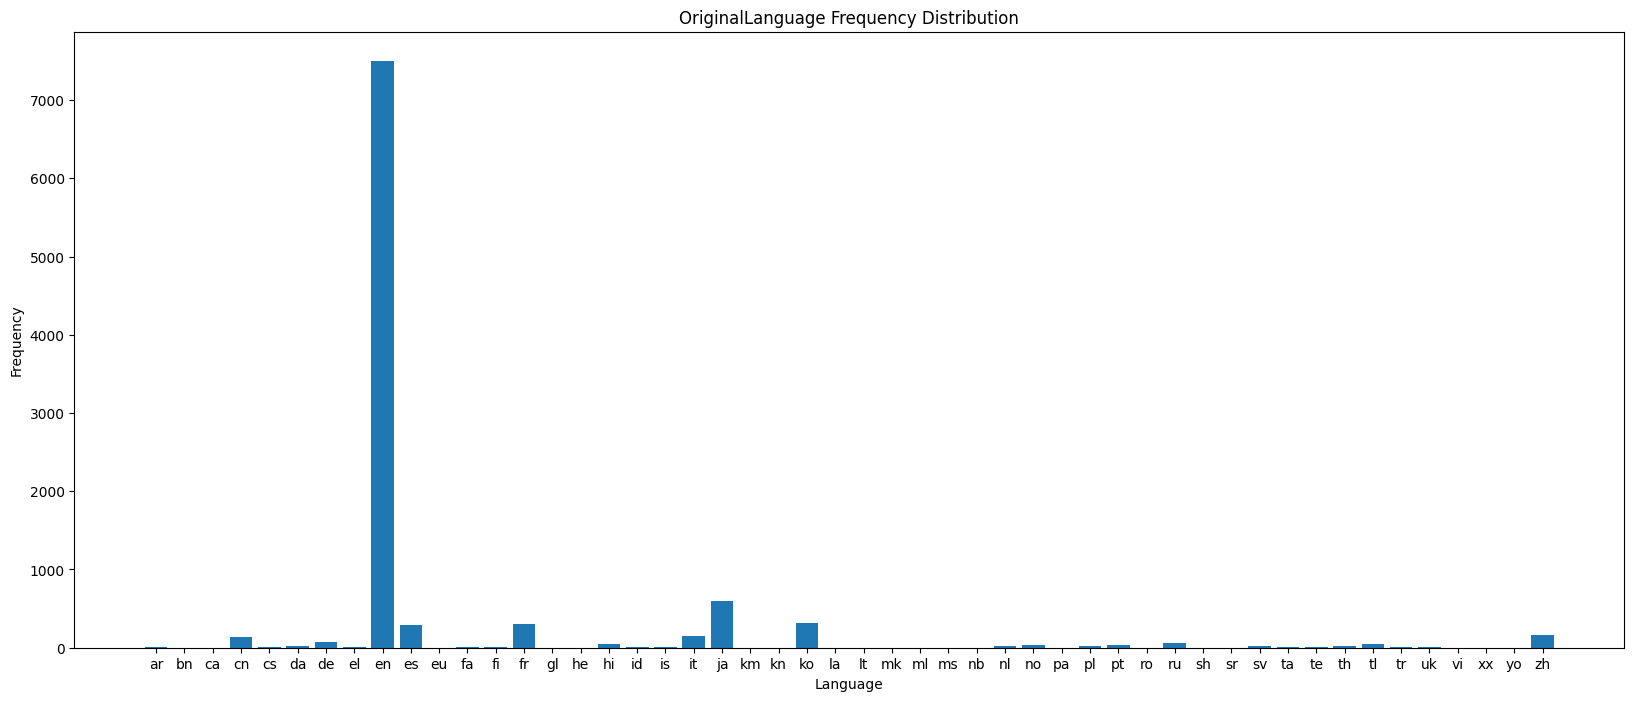

In [41]:
# Visualizing category distribution for original language
plt.figure(figsize=(20, 8))
plt.bar(ol_df.index, ol_df['Id'])
plt.title('OriginalLanguage Frequency Distribution')
plt.ylabel('Frequency')
plt.xlabel('Language')
plt.show()

As can be seen, English 'en' has a considerable share compared to other languages. Therefore, we are going to limit this to two categories only, English and not_english

In [42]:
# method to transform OriginalLanguage
def replace_language(item):
    '''function to replace the original language by a binary form'''
    if item == 'en':
        return 1
    else:
        return 0

In [43]:
df['OriginalLanguage'] = df['OriginalLanguage'].apply(replace_language)

In [44]:
df['OriginalLanguage'].head()

0    1
1    1
2    1
3    1
4    0
Name: OriginalLanguage, dtype: int64

In [45]:
df.dtypes

Id                           int64
OriginalLanguage             int64
OriginalTitle               object
Overview                    object
Popularity                 float64
ReleaseDate         datetime64[ns]
Title                       object
VoteAverage                float64
VoteCount                    int64
Budget                       int64
TagLine                     object
RunTime                      int64
Revenue                      int64
Genres                      object
North America                int64
Europe                       int64
Asia                         int64
Oceania                      int64
South America                int64
Africa                       int64
dtype: object

In [46]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

Note: In this second section, we discovered the data separating numerical from categoricals, then applied different strategies to transform the categoricals from plain text to numerical values; we had to use some assumptions to reduce the cardinality in some of the categorical data.

### 3. Inspect and impute nulls

In [47]:
#checking number of nulls by column
df.isna().sum()

Id                     0
OriginalLanguage       0
OriginalTitle          0
Overview              51
Popularity             0
ReleaseDate           21
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             2413
RunTime                0
Revenue                0
Genres                 0
North America          0
Europe                 0
Asia                   0
Oceania                0
South America          0
Africa                 0
dtype: int64

In [48]:
# TagLine nulls will be replaced to empty string throughout the code.
df['TagLine'].fillna('', inplace=True)

In [49]:
# Remove other nulls in ReleaseDate and Overview, there are just 72 records and there is not a reasonable way to impute those

df.dropna(inplace=True)

In [50]:
#checking number of nulls by column
df.isna().sum()

Id                  0
OriginalLanguage    0
OriginalTitle       0
Overview            0
Popularity          0
ReleaseDate         0
Title               0
VoteAverage         0
VoteCount           0
Budget              0
TagLine             0
RunTime             0
Revenue             0
Genres              0
North America       0
Europe              0
Asia                0
Oceania             0
South America       0
Africa              0
dtype: int64

### 4. Inspect and correct duplicated rows

In [51]:
df.duplicated().sum()

0

Note: There were not duplicated rows

### 5. create new cleaned dataset (movies_cleaned.csv)

In [52]:
# store final clearned dataset in CSV

df.to_csv('movies_cleaned.csv', index=False)

 ##  Outliers Identification

In [53]:
#reading the clean data
data = pd.read_csv('movies_cleaned.csv', lineterminator='\n', index_col='Id')
data.head()

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r
Id,,,,,,,,,,,,,,,,,,,
299054,1,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,They'll die when they're dead.,103,30000000,"Action, Adventure, Thriller",0,0,0,0,0,0
926393,1,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,Justice knows no borders.,109,176933602,"Action, Thriller, Crime",1,0,0,0,0,0
1034062,1,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,Neon lights... Suits with shoulder pads... Jum...,80,0,"Animation, Action, Fantasy",1,0,0,0,0,0
575264,1,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,We all share the same fate.,164,567148955,"Action, Thriller",1,0,0,0,0,0
1151534,0,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,Attempting to survive in the middle of nowhere...,109,0,"Thriller, Drama",0,0,0,0,0,0


In [54]:
# Indentifing the numercial columns in the clean dataset
data.select_dtypes(include=['int', 'float']).columns

Index(['OriginalLanguage', 'Popularity', 'VoteAverage', 'VoteCount', 'Budget',
       'RunTime', 'Revenue', 'North America', 'Europe', 'Asia', 'Oceania',
       'South America', 'Africa\r'],
      dtype='object')

In [55]:
# Filtering out the discrete numerical columns (those are categorical that were enconded in previous steps)
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']
numerical_df = data[numerical_columns]

In [56]:
numerical_df.describe()

,Popularity,VoteAverage,VoteCount,Budget,RunTime,Revenue
count,9930.000000,9930.000000,9930.000000,9.930000e+03,9930.000000,9.930000e+03
mean,34.311619,6.393766,1631.536254,2.057864e+07,102.287915,6.267203e+07
std,84.601478,1.325808,2967.943725,3.888475e+07,26.778256,1.566993e+08
min,13.049000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,15.589250,6.000000,173.000000,0.000000e+00,91.000000,0.000000e+00
50%,20.098500,6.600000,570.000000,2.500000e+06,101.000000,3.929278e+06
75%,30.433000,7.100000,1679.000000,2.500000e+07,115.000000,5.498877e+07
max,3741.062000,10.000000,34628.000000,4.600000e+08,400.000000,2.923706e+09


### Boxplots

In [57]:
# Function to create boxplot to see percetiles and outliers presence

def create_box_plot(column, title, r1, r2):
    q3 = np.percentile(column, 75)
    q1 = np.percentile(column, 25)
    IQR = q3 - q1
    upper_fence = q3 + IQR * 1.5
    lower_fence = q1 - IQR * 1.5

    fig = plt.figure(1, figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title + " Boxplot")
    
    r1 = min(r1, lower_fence)
    r2 = max(r2, upper_fence)

    ax.boxplot(column , vert=False, manage_ticks=True)
    ax.set_xlabel('values')
    ax.set_yticks([1])
    ax.set_yticklabels([title])

    quantiles = np.quantile(column , np.array([0.00, 0.25, 0.50, 0.75]))
    quantiles = np.append(quantiles, upper_fence)
    quantiles = np.insert(quantiles, 0, lower_fence)
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
              color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    plt.xlim(r1, r2)
    ax.tick_params(axis='x', labelsize=8)
    plt.show()

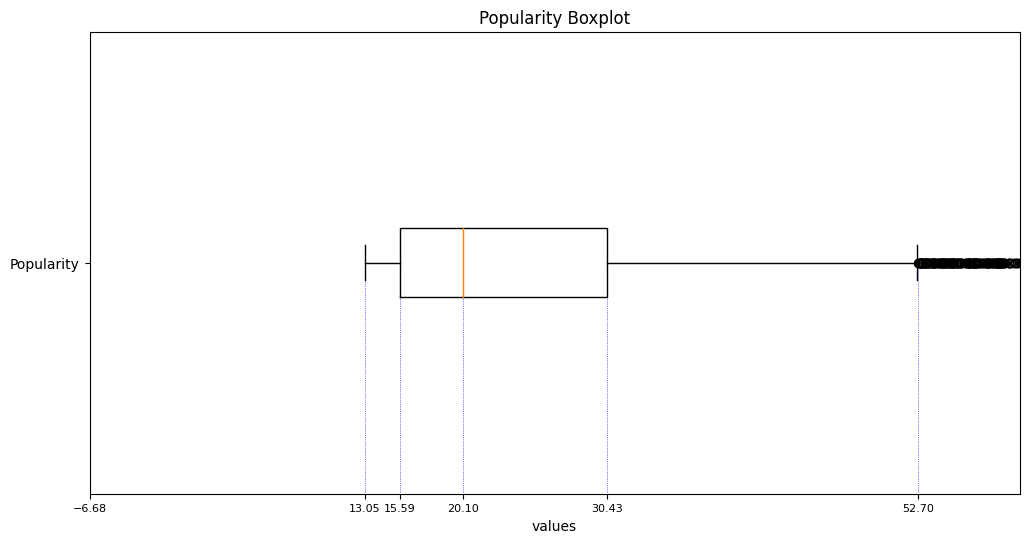

In [58]:
# Popularity Boxplot
create_box_plot(data['Popularity'], 'Popularity', 0, 60)

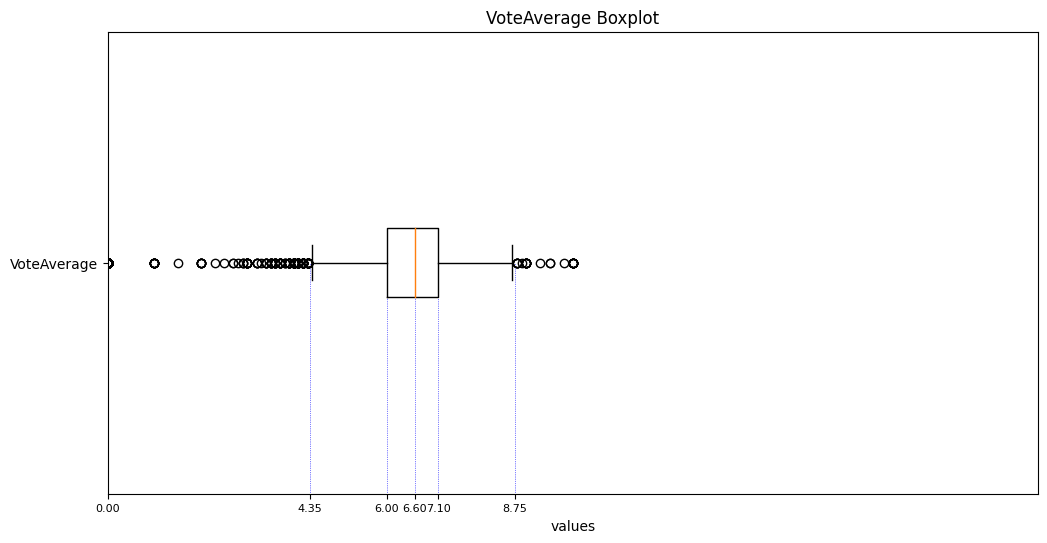

In [59]:
# VoteAverage Boxplot
create_box_plot(data['VoteAverage'], 'VoteAverage', 0, 20)

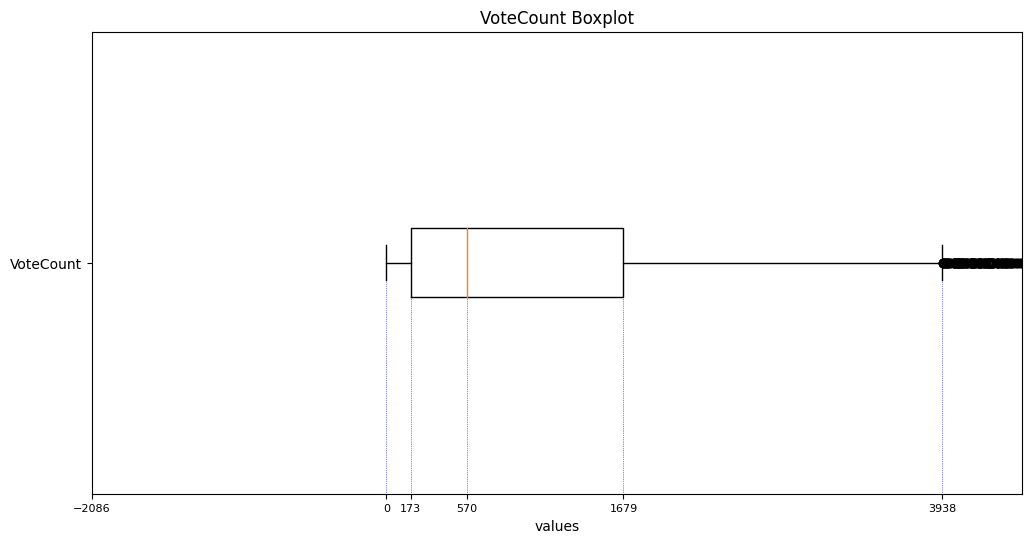

In [60]:
# VoteCount Boxplot
create_box_plot(data['VoteCount'], 'VoteCount', 0, 4500)

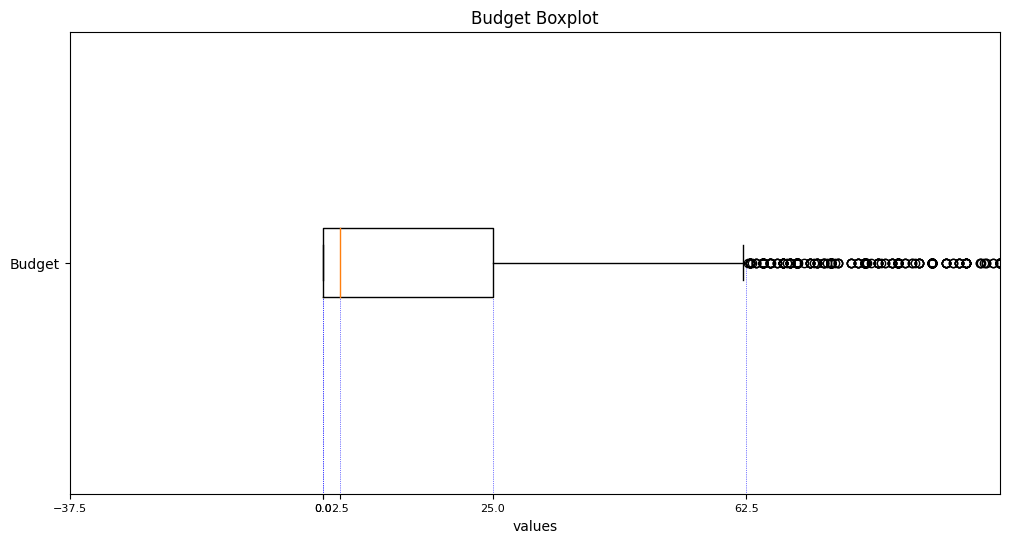

In [61]:
# Scaled Budget Boxplot
create_box_plot((data['Budget']) / 1000000, 'Budget', 0, 100)

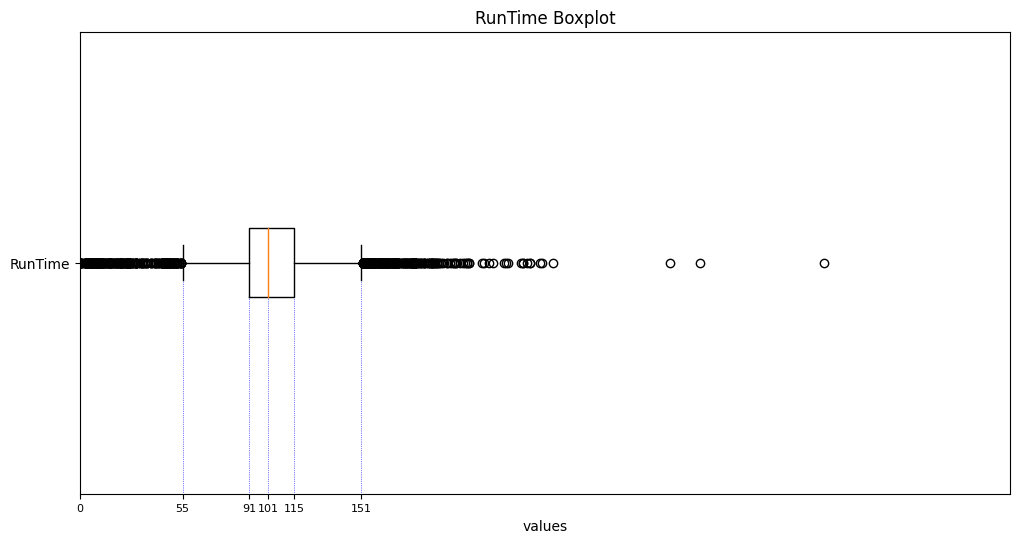

In [62]:
# RunTime Boxplot
create_box_plot(data['RunTime'], 'RunTime', 0, 500)

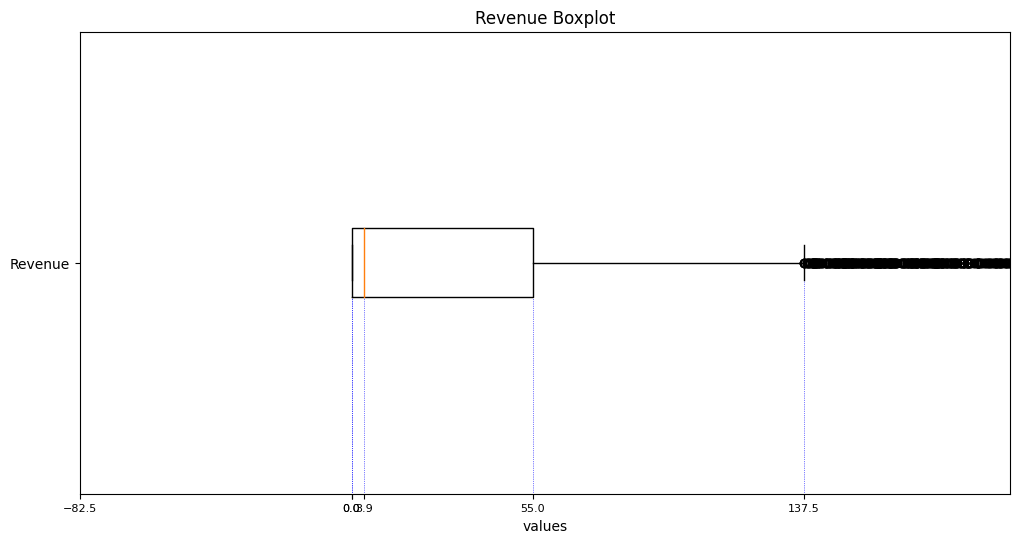

In [63]:
# Scaled Revenue Boxplot
create_box_plot((data['Revenue'] / 1000000), 'Revenue', 0, 200)

Notes:

The function "create_box_plot" was created to inspect the outliers in the columns visually:

1. The function accepts three arguments; "column" which is the data for the boxplot, "title" which impacts the title and label we want to add to the boxplot. And (r1,r2), which is the range of data we want to plot.
2. It calculates the percentiles q3, q1, and the IQR to compute the upper and lower fences to be included in the boxplot.
3. The quantiles  [0, 25, 50, 75] are calculated and stored in an array called "quantiles". The array is modified with the lower fence at position 0 and the upper fence at the last position.
4. The quantiles array is passed to the method, .vlines which handles the vertical lines
5. The quantiles array is also passed to the .set_xticks to see the numbers in the x-axis in the boxplot
6. Finally, the range in X to plot is established using the method .xlim

The plots show:

1. Popularity: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 15.59, 50% of the data fall below 20.1, 75% of the data fall below 30.33. The upper extreme is at 52, and the lower extreme is at 13.05.

2. VoteAverage: This shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 6.00, 50% of the data fall below 6.60, 75% of the data fall below 7.10. The upper extreme is at 8.75, and the lower extreme is at 4.35.

3. VoteCount: Shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 25% of the data fall below 170, 50% of the data fall below 564, and 75% of the data fall below 1668. The upper extreme is at 3915, and the lower extreme is at 0.

4. Budget: The budget was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 2.2M, and 75% of the data fall below 25M. The upper extreme is at 62.5M, and the lower extreme is at 0.

5. RunTime: Shows a symmetric distribution and the presence of outliers in the upper and lower levels. 25% of the data fall below 91 min, 50% of the data fall below 101 min, and 75% of the data fall below 115 min. The upper extreme is at 151 min, and the lower extreme is at 55 min.

6. Revenue: Revenue was scaled down to facilitate plotting. It shows a distribution positively skewed (right-skewed) and the presence of outliers in the upper level. 50% of the data fall below 8.8 M, and 75% of the data fall below 54.6 M. The upper extreme is at 136.5 M, and the lower extreme is at 0.




## Outliers Handling

### Method 1: Quantile-based Flooring and Capping

In [64]:
# Function to apply flooring and capping method for outlier handling

def apply_flooring_capping(data, floor, cap):
    floor_q = data.quantile(0.01)
    cap_q = data.quantile(0.99)
    result = data.copy()
    result = np.where(result < floor_q, floor_q, result)
    result = np.where(result > cap_q, cap_q, result)
    return result
    

In [65]:
# Function to plot two boxplot
def create_boxplots(arr1, arr2, r1, r2, label1, label2):
    ax = sns.boxplot(data=[arr1, arr2], orient='h')
    plt.xlim(r1, r2)
    ax.set_yticklabels([label1, label2]) 

In [66]:
# Applying quantile-based flooring and capping to Popularity

popularity_fc = apply_flooring_capping(data['Popularity'], 0.01, 0.99)

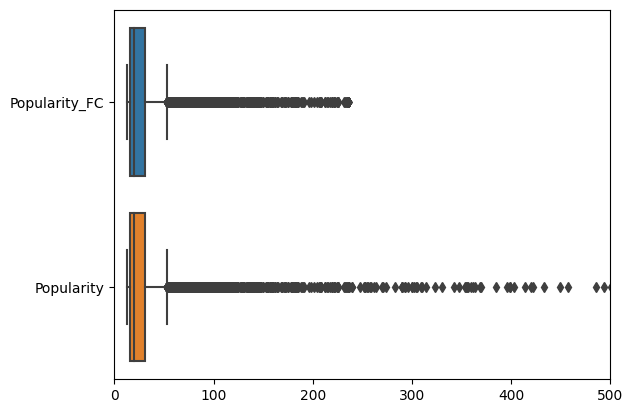

In [67]:
# Boxplots to compate Popularity with and without quantile-based flooring and capping
create_boxplots(popularity_fc, data['Popularity'], 0, 500, 'Popularity_FC', 'Popularity')

In [68]:
# Applying quantile-based flooring and capping to VoteAverage

vote_average_fc = apply_flooring_capping(data['VoteAverage'], 0.01, 0.99)

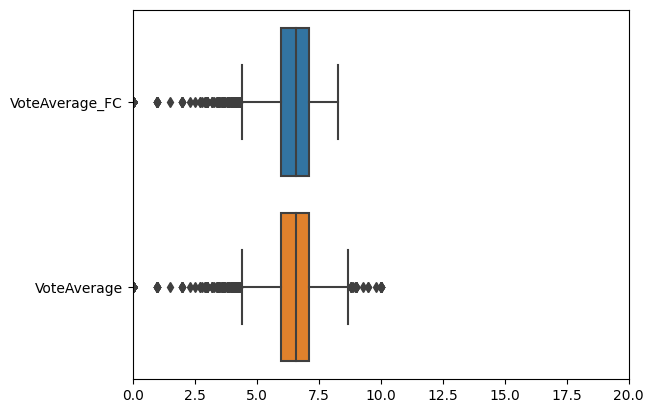

In [69]:
# Boxplots to compate VoteAverage with and without quantile-based flooring and capping
create_boxplots(vote_average_fc, data['VoteAverage'], 0, 20, 'VoteAverage_FC', 'VoteAverage')

In [70]:
# Applying quantile-based flooring and capping to VoteCount

vote_count_fc = apply_flooring_capping(data['VoteCount'], 0.01, 0.99)

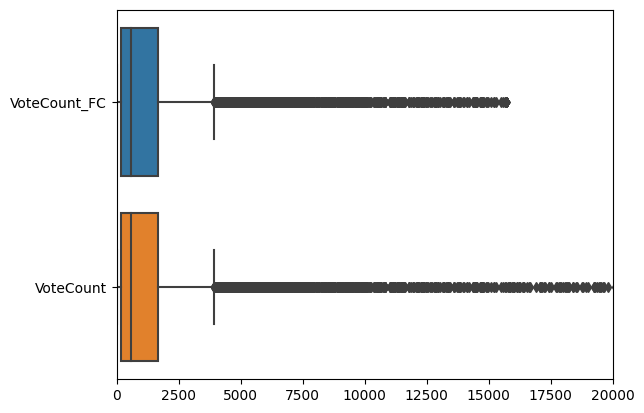

In [71]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(vote_count_fc, data['VoteCount'], 0, 20000, 'VoteCount_FC', 'VoteCount')

In [72]:
# Applying quantile-based flooring and capping to Budget

budget_fc = apply_flooring_capping(data['Budget'], 0.01, 0.99)

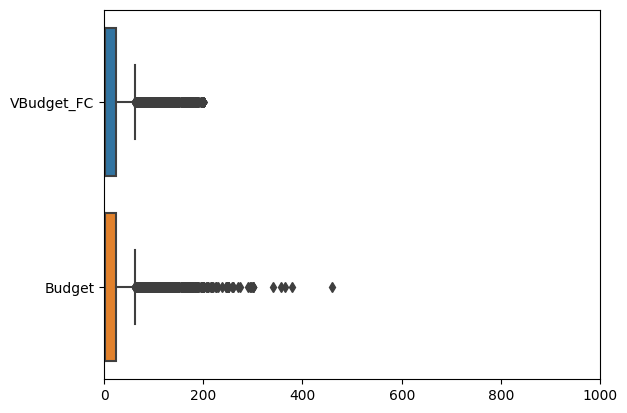

In [73]:
# Boxplots to compate VoteCount with and without quantile-based flooring and capping
create_boxplots(budget_fc / 1000000, data['Budget'] / 1000000, 0, 1000, 'VBudget_FC', 'Budget')

In [74]:
# Applying quantile-based flooring and capping to RunTime

runtime_fc = apply_flooring_capping(data['RunTime'], 0.01, 0.99)

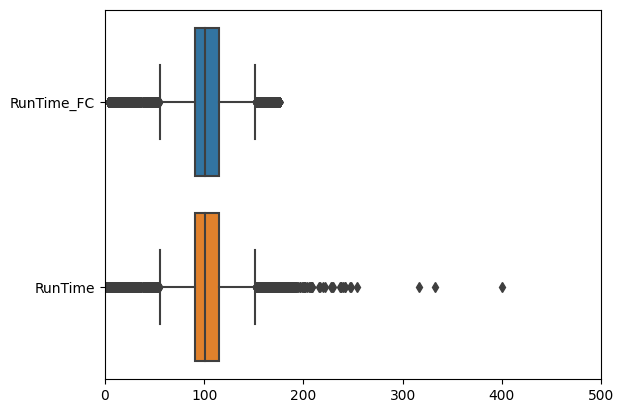

In [75]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(runtime_fc, data['RunTime'], 0, 500, 'RunTime_FC', 'RunTime')

In [76]:
# Applying quantile-based flooring and capping to Revenue

revenue_fc = apply_flooring_capping(data['Revenue'], 0.01, 0.99)

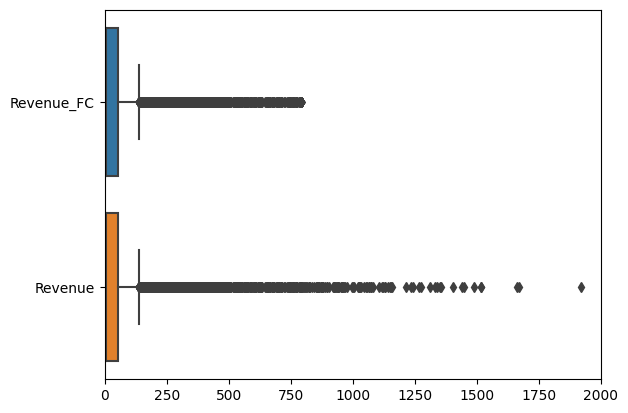

In [77]:
# Boxplots to compate RunTime with and without quantile-based flooring and capping
create_boxplots(revenue_fc / 1000000, data['Revenue'] / 1000000, 0, 2000, 'Revenue_FC', 'Revenue')

### Method 2: Trimming 

In [78]:
numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget','RunTime', 'Revenue']

In [79]:
# method to return a copy of a data frame after trimming the numerical valiables
def get_trimmed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        upper_q = np.quantile(data[col], 0.75)
        lower_q = np.quantile(data[col], 0.25)
        IQR = upper_q - lower_q
        upper_whisker = upper_q + (1.5 * IQR)
        lower_whisker = lower_q - (1.5 * IQR)
        indexes = result[(result[col] > upper_whisker) | (result[col] < lower_whisker)].index
        print(f'Droping {indexes.shape[0]} indexes for {col}')
        result.drop(indexes, inplace=True)
        print(f'Data final shape {result.shape}')
    return result  
    

In [80]:
# getting trimmed new data
trimmed_data = get_trimmed_data(data, numerical_columns)

Droping 1026 indexes for Popularity
Data final shape (8904, 19)
Droping 400 indexes for VoteAverage
Data final shape (8504, 19)
Droping 657 indexes for VoteCount
Data final shape (7847, 19)
Droping 390 indexes for Budget
Data final shape (7457, 19)
Droping 407 indexes for RunTime
Data final shape (7050, 19)
Droping 257 indexes for Revenue
Data final shape (6793, 19)


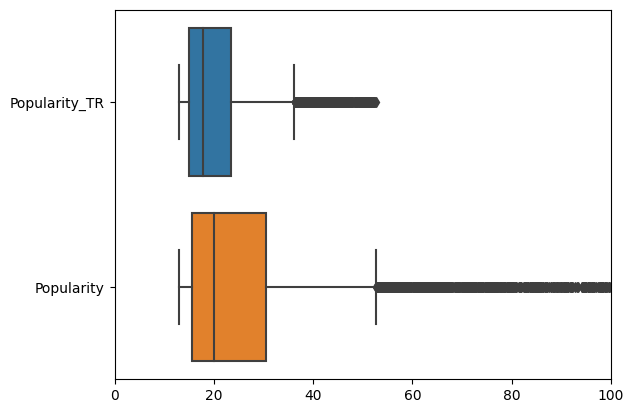

In [81]:
# Boxplots to compare trimmed and no-trimmed Popularity
create_boxplots(trimmed_data['Popularity'], data['Popularity'], 0, 100, 'Popularity_TR', 'Popularity')

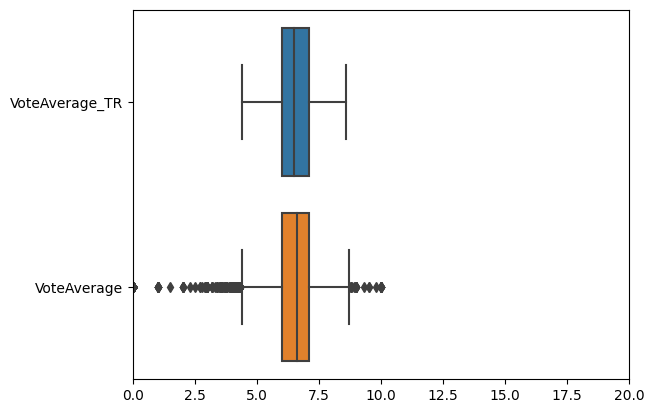

In [82]:
# Boxplots to compare trimmed and no-trimmed 'VoteAverage'
create_boxplots(trimmed_data['VoteAverage'], data['VoteAverage'], 0, 20, 'VoteAverage_TR', 'VoteAverage')

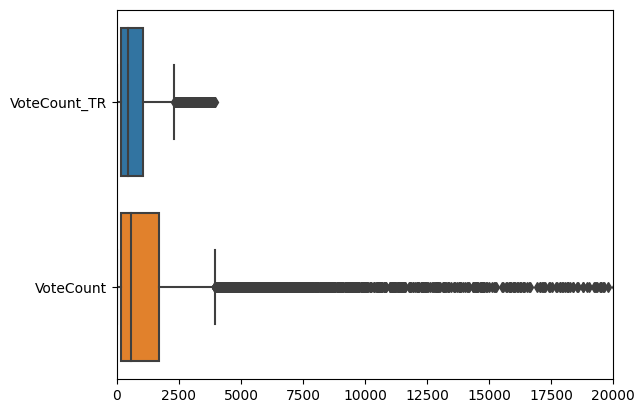

In [83]:
# Boxplots to compare trimmed and no-trimmed VoteCount
create_boxplots(trimmed_data['VoteCount'], data['VoteCount'], 0, 20000, 'VoteCount_TR', 'VoteCount')

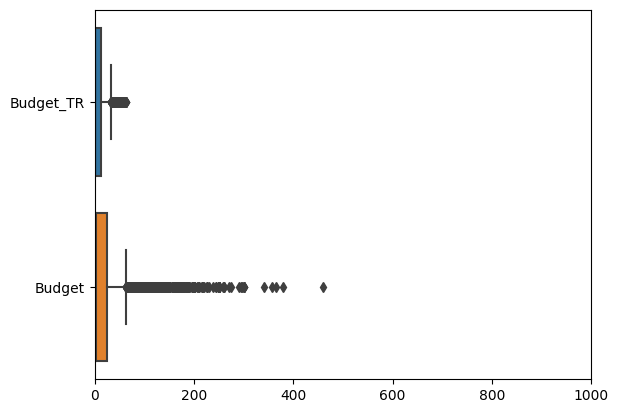

In [84]:
# Boxplots to compare trimmed and no-trimmed Budget
create_boxplots(trimmed_data['Budget'] / 1000000, data['Budget'] / 1000000, 0, 1000, 'Budget_TR', 'Budget')

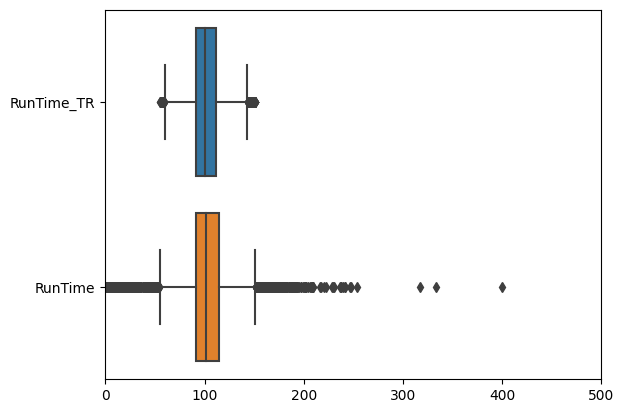

In [85]:
# Boxplots to compare trimmed and no-trimmed RunTime
create_boxplots(trimmed_data['RunTime'], data['RunTime'], 0, 500, 'RunTime_TR', 'RunTime')

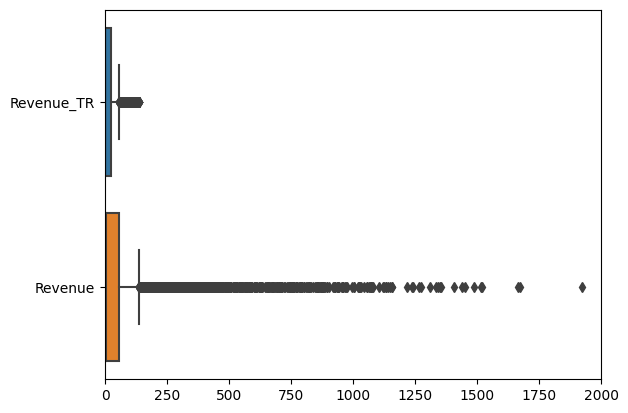

In [86]:
# Boxplots to compare trimmed and no-trimmed Revenue
create_boxplots(trimmed_data['Revenue'] / 1000000, data['Revenue']/1000000, 0, 2000, 'Revenue_TR', 'Revenue')

### Method 3: Log Transformation

In [87]:
# Function to apply log tranformation to data, returns a copy with transformed columns
def get_log_transformed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        result[col] = result[col].map(lambda x: np.log(x) if x > 0 else 0)
    return result
    

In [88]:
# create graph to compare boxplots
def pair_boxplots(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].boxplot(arr1, vert=False)
    axes[0].set_title(f'Boxplot {label1}')
    axes[1].boxplot(arr2, vert=False)
    axes[1].set_title(f'Boxplot {label2}')
    plt.show()
    
# create graph to compare histograms
def pair_histograms(arr1, arr2, label1, label2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(arr1, bins=20)
    axes[0].set_title(f'Histogram {label1}')
    axes[1].hist(arr2, bins=20)
    axes[1].set_title(f'Histogram {label2}')
    plt.show()


In [89]:
# Understanding skewness correction for Popularity
log_transformed_data = get_log_transformed_data(data, numerical_columns)
skewness_td = log_transformed_data['Popularity'].skew().round(2)
skewness_d = data['Popularity'].skew().round(2)
print(f'Skewness transformed data {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data 2.13
Skewness data: 20.12


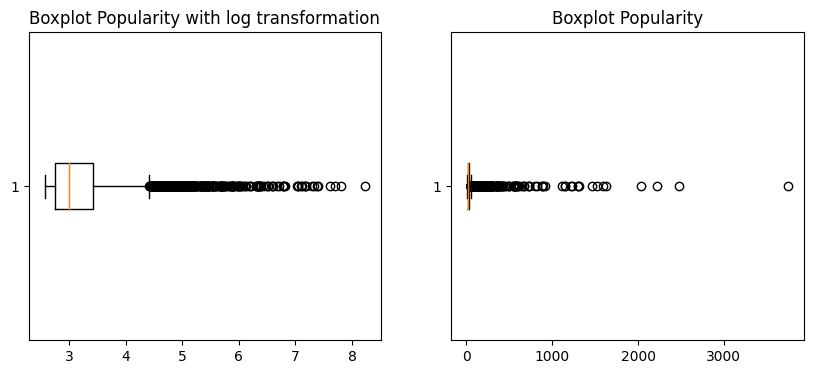

In [90]:
# boxplots for Popularity with and without log transformation
pair_boxplots(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

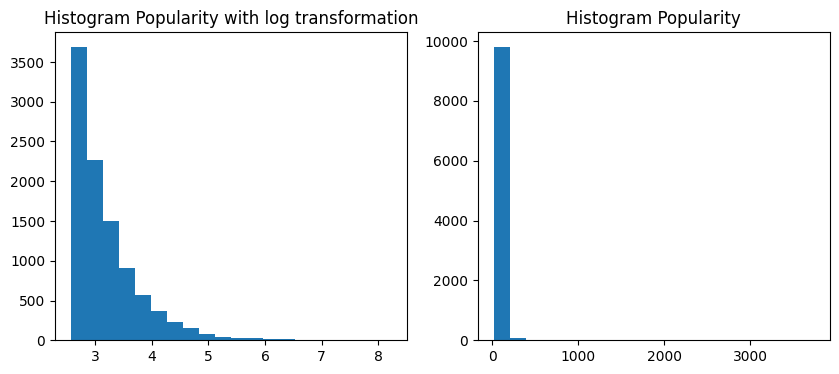

In [91]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Popularity'], data['Popularity'], 'Popularity with log transformation', 'Popularity')

In [92]:
# Understanding skewness correction for VoteAverage
skewness_td = log_transformed_data['VoteAverage'].skew().round(2)
skewness_d = data['VoteAverage'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -4.46
Skewness data: -2.58


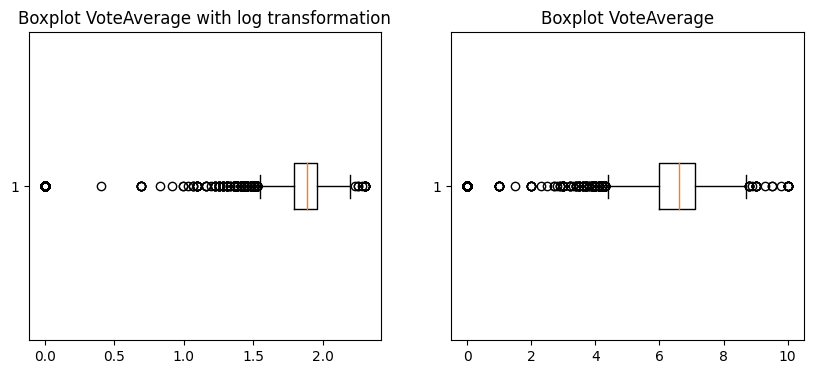

In [93]:
# boxplots for VoteAverage with and without log transformation
pair_boxplots(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

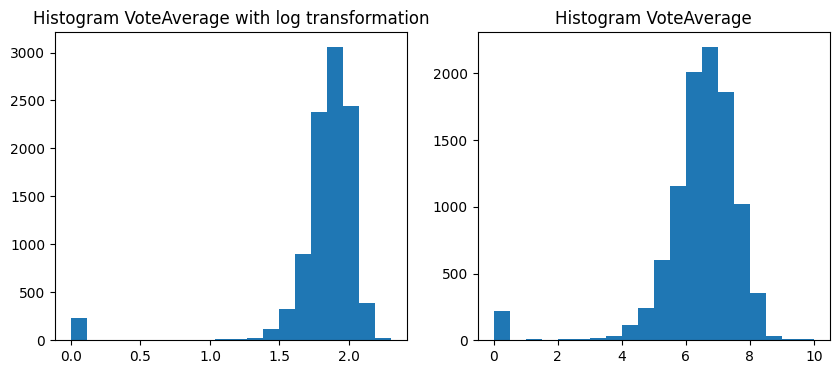

In [94]:
# histograms for VoteAverage with and without log transformation
pair_histograms(log_transformed_data['VoteAverage'], data['VoteAverage'], 'VoteAverage with log transformation', 'VoteAverage')

In [95]:
# Understanding skewness correction for VoteCount
skewness_td = log_transformed_data['VoteCount'].skew().round(2)
skewness_d = data['VoteCount'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.98
Skewness data: 4.03


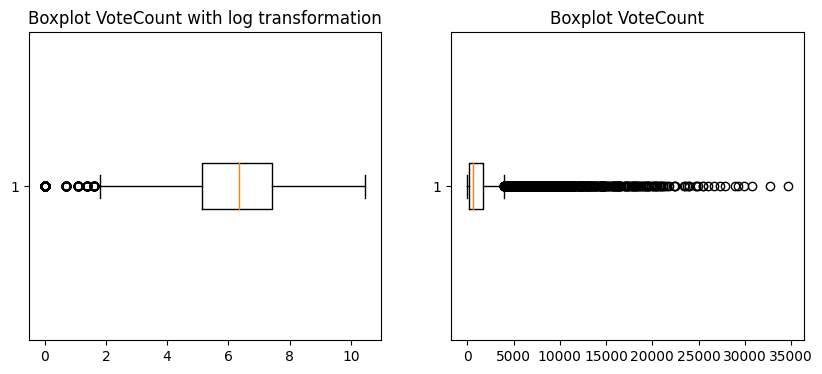

In [96]:
# boxplots for VoteCount with and without log transformation
pair_boxplots(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

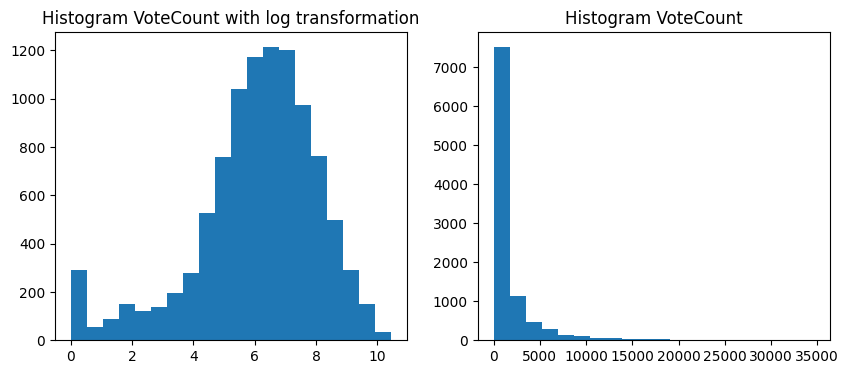

In [97]:
# histograms for VoteCount with and without log transformation
pair_histograms(log_transformed_data['VoteCount'], data['VoteCount'], 'VoteCount with log transformation', 'VoteCount')

In [98]:
#Understanding skewness correction for Budget
skewness_td = log_transformed_data['Budget'].skew().round(2)
skewness_d = data['Budget'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.17
Skewness data: 3.23


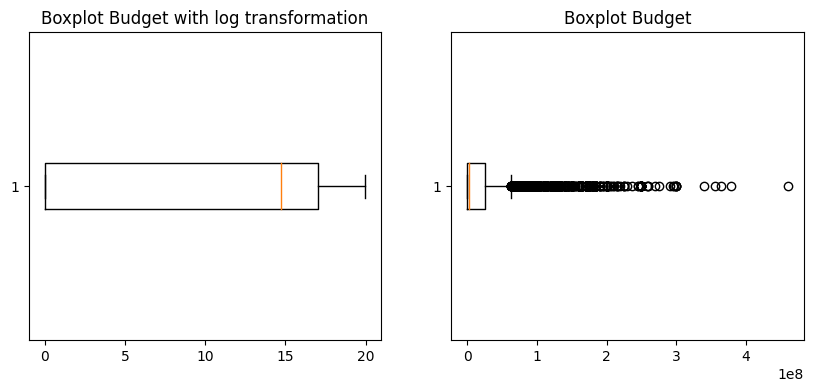

In [99]:
# boxplots for Budget with and without log transformation
pair_boxplots(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

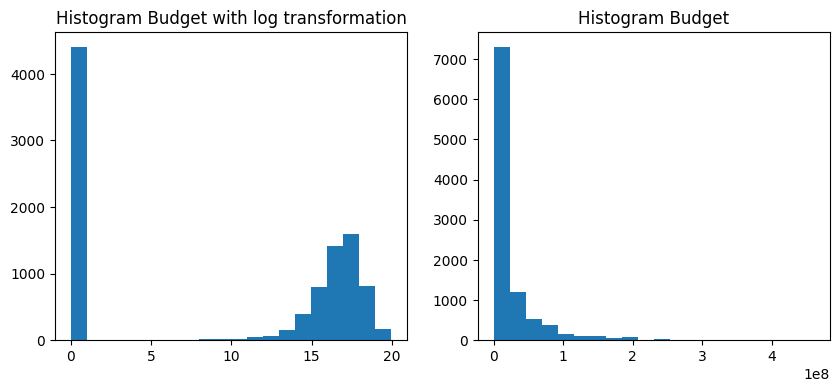

In [100]:
# histograms for Popularity with and without log transformation
pair_histograms(log_transformed_data['Budget'], data['Budget'], 'Budget with log transformation', 'Budget')

In [101]:
# Understanding skewness correction for RunTime
skewness_td = log_transformed_data['RunTime'].skew().round(2)
skewness_d = data['RunTime'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -5.77
Skewness data: -0.23


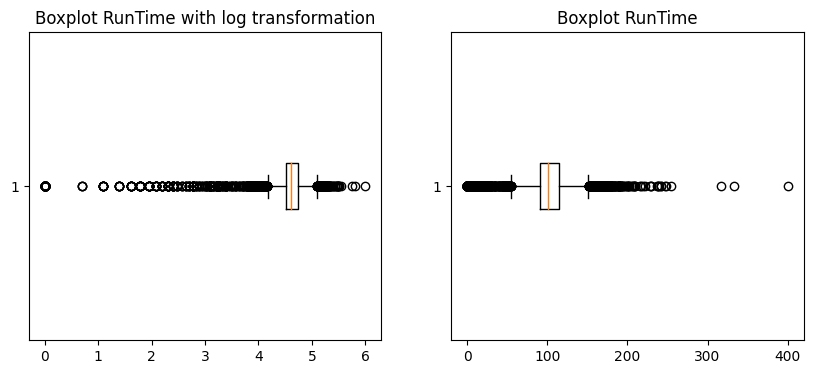

In [102]:
# boxplots for RunTime with and without log transformation
pair_boxplots(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

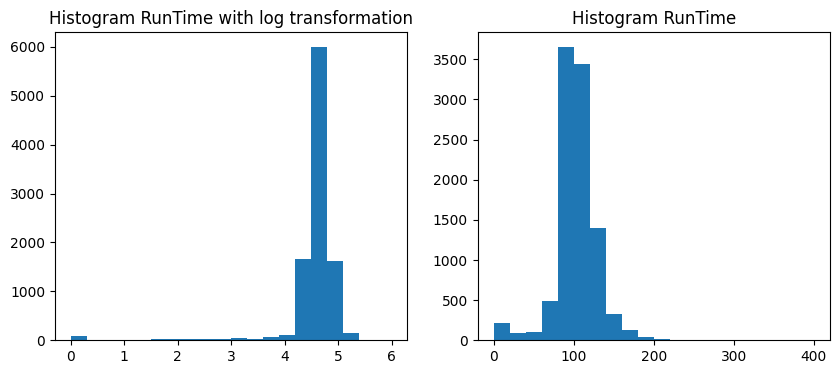

In [103]:
# histograms for RunTime with and without log transformation
pair_histograms(log_transformed_data['RunTime'], data['RunTime'], 'RunTime with log transformation', 'RunTime')

In [104]:
# Understanding skewness correction for Revenue
skewness_td = log_transformed_data['Revenue'].skew().round(2)
skewness_d = data['Revenue'].skew().round(2)
print(f'Skewness transformed data: {skewness_td}')
print(f'Skewness data: {skewness_d}')

Skewness transformed data: -0.26
Skewness data: 5.88


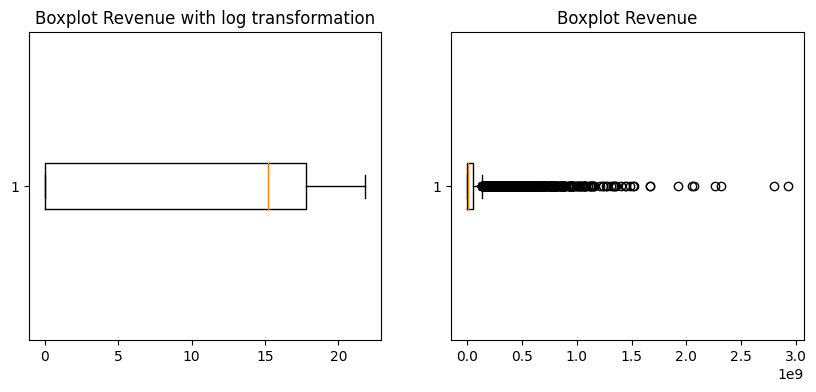

In [105]:
# boxplots for Revenue with and without log transformation
pair_boxplots(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

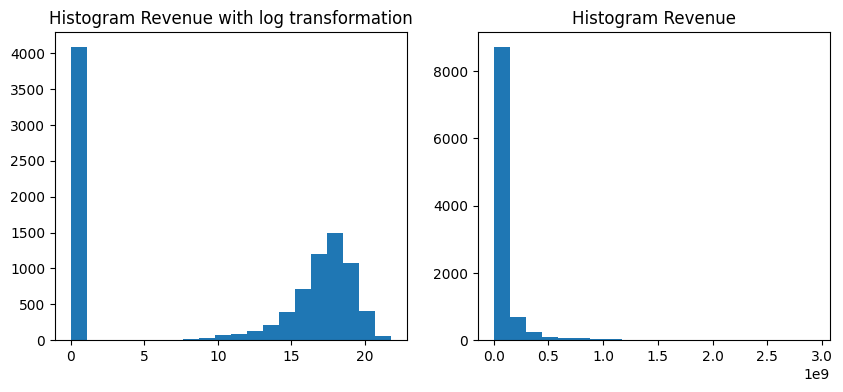

In [106]:
# histograms for Revenue with and without log transformation
pair_histograms(log_transformed_data['Revenue'], data['Revenue'], 'Revenue with log transformation', 'Revenue')

In [107]:
# applying Trimming to log transformed Popularity
logt_trimmed_data = get_trimmed_data(log_transformed_data, ['Popularity'])

Droping 474 indexes for Popularity
Data final shape (9456, 19)


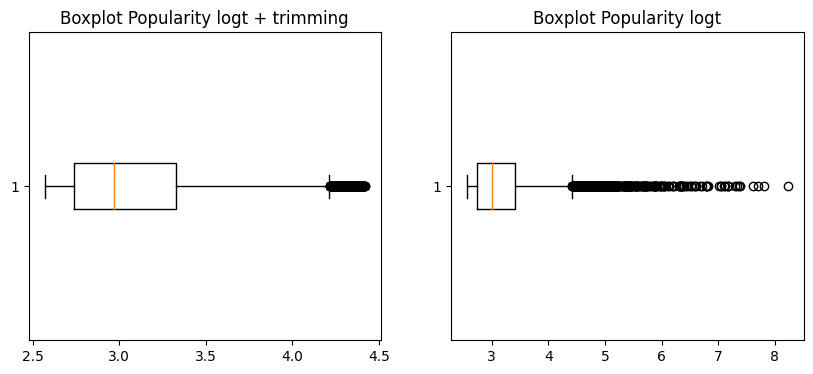

In [108]:
# final Popularity log transformation + trimming

pair_boxplots(logt_trimmed_data['Popularity'], log_transformed_data['Popularity'], 'Popularity logt + trimming', 'Popularity logt')

In [109]:
# final dataset without outliers

# 1 Trimming columns 'VoteAverage' and 'RunTime'
movies_data_trimmed = get_trimmed_data(data, ['VoteAverage', 'RunTime'])

# Log tranformation for 'Budget', 'Revenue', 'VoteCount' and 'Popularity'
movies_data_log_transform = get_log_transformed_data(movies_data_trimmed, ['Budget', 'Revenue', 'VoteCount', 'Popularity'])

# Apply trimming to the log tranformed 'Popularity'

movies_data = get_trimmed_data(movies_data_log_transform, ['Popularity'])


Droping 425 indexes for VoteAverage
Data final shape (9505, 19)
Droping 545 indexes for RunTime
Data final shape (8960, 19)
Droping 420 indexes for Popularity
Data final shape (8540, 19)


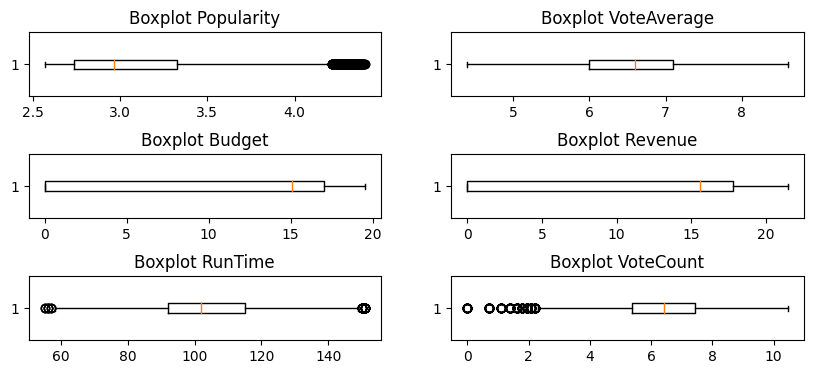

In [110]:
# boxplot to final confirm all distributions

fig, axes = plt.subplots(3, 2, figsize=(10, 4))
plt.subplots_adjust(hspace=0.9)
axes[0][0].boxplot(movies_data['Popularity'], vert=False)
axes[0][0].set_title('Boxplot Popularity')
axes[0][1].boxplot(movies_data['VoteAverage'], vert=False)
axes[0][1].set_title('Boxplot VoteAverage')
axes[1][0].boxplot(movies_data['Budget'], vert=False)
axes[1][0].set_title('Boxplot Budget')
axes[1][1].boxplot(movies_data['Revenue'], vert=False)
axes[1][1].set_title('Boxplot Revenue')
axes[2][0].boxplot(movies_data['RunTime'], vert=False)
axes[2][0].set_title('Boxplot RunTime')
axes[2][1].boxplot(movies_data['VoteCount'], vert=False)
axes[2][1].set_title('Boxplot VoteCount')
plt.show()


In [111]:
# storing the final dataset as movies_data.csv
movies_data.to_csv('movies_data.csv')

Notes:

Quantile-based Flooring and Capping:

- Overall, it showed an improvement in skewness. However, for all the columns, we still got a significant presence of outliers.

Trimming:

- This method is not an option as a unique method to fix outliers due to a significant data loss. After trimming, the number of rows was reduced from 9979 to just 6796 (32%). Additionally, in terms of improving outliers, although it reduced the skewness for some columns, it was more effective for 'VoteAverage' and 'RunTime' (both have the most symmetric distributions). The other columns still have a significant presence of outliers.
    
Log Transformation

- This method presents a small change for those columns that already have a symmetrical distribution, such as RunTime and VoteAverage. On the other hand, for those skewed distributions, this method allowed a more symmetrical one, as seen in Popularity, VoteCount, Budget, and Revenue.

- This transformation successfully removed outliers for 'Budget', 'Revenue' and 'VoteCount'. Additionally, it improved the distributions for Popularity and VoteCount.

Considering the results applying each of the methods for all the columns, we decided to remove the outliers as follows:

- 'VoteAverage' and 'RunTime' -> Trimming
- 'Budget', 'Revenue' and VoteCount-> Log Tranformation
- 'Popularity' -> Log Tranformation + Trimming

Using above strategy, we were able to remove ourliers and improve skewness for the columns.

Finally, we stored the dataset as movies_data.csv





# Text Wrangling

In [112]:
#reading the data without outliers
data = pd.read_csv('movies_data.csv', lineterminator='\n', index_col='Id')
data.head(2)

,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r\r
Id,,,,,,,,,,,,,,,,,,,
27205,1,Inception,"Cobb, a skilled thief who commits corporate es...",4.401216,2010-07-15,Inception,8.4,10.452418,18.890684,Your mind is the scene of the crime.,148,20.531540,"Action, ScienceFiction, Adventure",1,1,0,0,0,0
497698,1,Black Widow,"Natasha Romanoff, also known as Black Widow, c...",4.399596,2021-07-07,Black Widow,7.3,9.142918,19.113828,Her world. Her secrets. Her legacy.,134,19.755027,"Action, Adventure, ScienceFiction",1,0,0,0,0,0


In [113]:
data.isna().sum()

OriginalLanguage       0
OriginalTitle          0
Overview               0
Popularity             0
ReleaseDate            0
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             1769
RunTime                0
Revenue                0
Genres                 5
North America          0
Europe                 0
Asia                   0
Oceania                0
South America          0
Africa\r\r             0
dtype: int64

In [114]:
data['TagLine'].fillna('', inplace=True)

In [115]:
# Some extra nulls where creating when parsing genres
data.dropna(inplace=True)

## Checking Language

In [116]:
# checking textual data for non english columns
data[data['OriginalLanguage'] == 0][['OriginalTitle', 'Title', 'Overview', 'TagLine']]

,OriginalTitle,Title,Overview,TagLine
Id,,,,
843794,정이,JUNG_E,"On an uninhabitable 22nd-century Earth, the ou...",AI Combat Warrior Will be Unleashed.
729854,콘크리트 유토피아,Concrete Utopia,The world has been reduced to rubble by a mass...,We believe we are chosen
28676,Schiave bianche: violenza in Amazzonia,Amazonia: The Catherine Miles Story,A young woman seeks vengeance and finds love w...,Only one thing kept her alive.
985883,Do Not Disturb,Do Not Disturb,A middle-aged man emerges from a pandemic slum...,A Night with Ayzek.
397567,신과함께-죄와 벌,Along with the Gods: The Two Worlds,"Having died unexpectedly, firefighter Ja-hong ...",Fate continues even after death
...,...,...,...,...
991814,カラダ探し,Re/Member,Six high schoolers stuck in a murderous time l...,Find the body.
659959,Été 85,Summer of 85,What do you dream of when you're 16-years-old ...,
413543,Dear Zindagi,Dear Zindagi,An unconventional thinker helps a budding cine...,


In [117]:
#Filtering out OriginalTitle as it contains other languages and Title is the same column but in english
data.drop(columns=['OriginalTitle'], inplace=True)

## Remove punctuations, numbers and stop words

In [118]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string

# Remove stop words
eng_stop_words = stopwords.words('english')
def process_text(text):
    """
    Process a string to remove stop words
    """
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize and remove stop words
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() not in eng_stop_words and not word.isnumeric()]
    return " ".join(filtered_words)

# Processing the columns: 'Overview', 'Title', 'Genres

data['Overview'] = data['Overview'].apply(process_text)
data['Title'] = data['Title'].apply(process_text)
data['Genres'] = data['Genres'].apply(process_text)
data['TagLine'] = data['TagLine'].apply(process_text)

In [120]:
# after cleaning, title ended up with some empty strings
# We need to remove this rows as those will be parsed as nulls when imported
indexes_to_remove = data[data['Title'] == ''].index

In [121]:
data.drop(indexes_to_remove, inplace=True)

In [122]:
# checking empty string in Genres
len(data[data['Genres'] == ''].index)

0

In [123]:
# checking empty string in Overview
len(data[data['Overview'] == ''].index)

0

In [124]:
# storing the final dataset as movies_data.csv
data.to_csv('movies_data_final.csv')

## Text Data Visualizations

In [125]:
data = pd.read_csv('movies_data_final.csv', lineterminator='\n', index_col='Id')

In [126]:
data.head(2)

,OriginalLanguage,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa\r\r\r
Id,,,,,,,,,,,,,,,,,,
27205,1,cobb skilled thief commits corporate espionage...,4.401216,2010-07-15,inception,8.4,10.452418,18.890684,mind scene crime,148,20.531540,action sciencefiction adventure,1,1,0,0,0,0
497698,1,natasha romanoff also known black widow confro...,4.399596,2021-07-07,black widow,7.3,9.142918,19.113828,world secrets legacy,134,19.755027,action adventure sciencefiction,1,0,0,0,0,0


In [127]:
# empty string in TagLine is parced as nulls, those are corrected before analysis
data['TagLine'].fillna('', inplace=True)

### Words Cloud

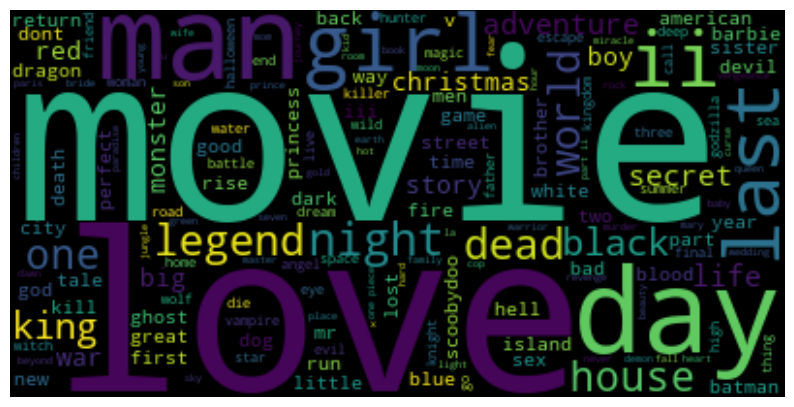

In [128]:
# Words Cloud Title
text = ' '.join(data['Title'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

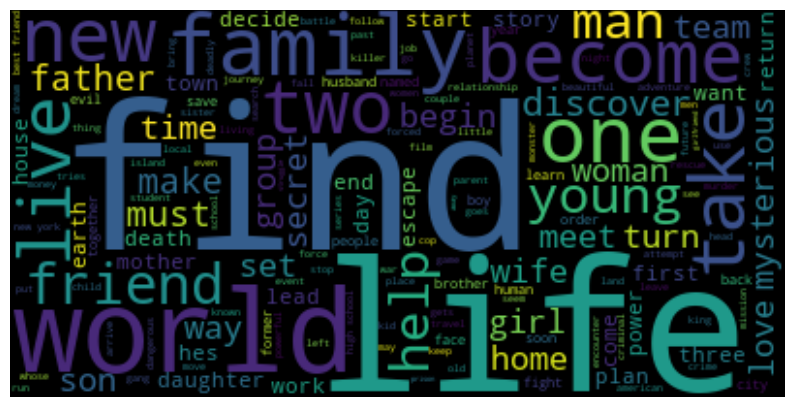

In [129]:
# Words Cloud Overview
text = ' '.join(data['Overview'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

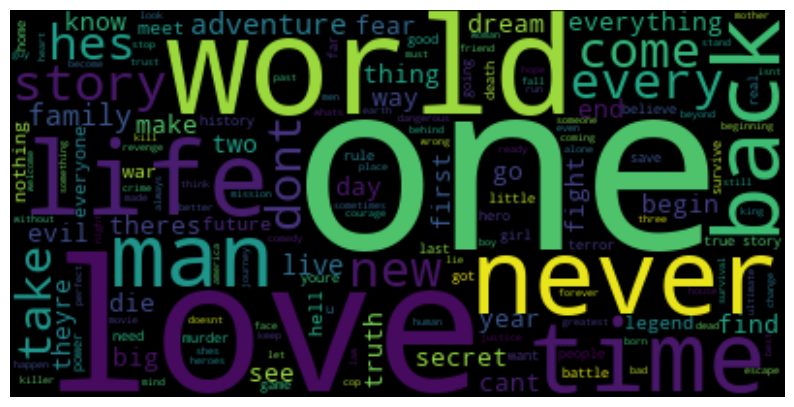

In [130]:
# Words Cloud TagLine
text = ' '.join(data['TagLine'])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Note: The Word Clouds shows that positive words are more frequent than negative words in either Overview or Title. For instance, we see words like Love, life, friend, and family. However, We can see some negative terms, too, such as bad, evil, and lost.

### Top Words

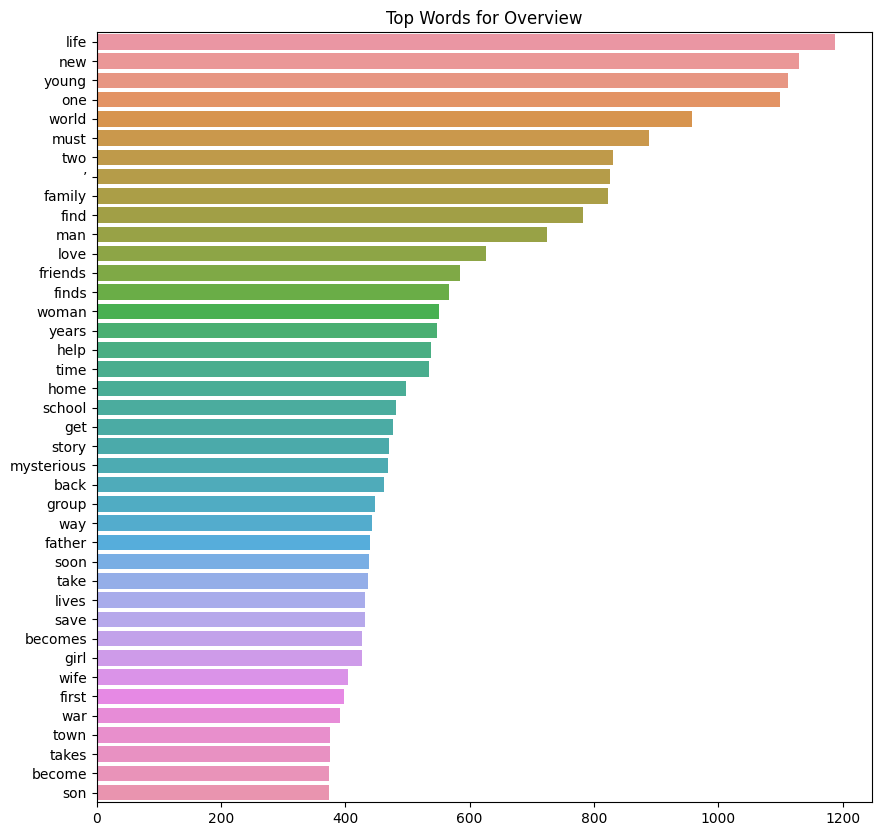

In [131]:
def plot_top_words_barchart(text, column):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        x.append(word)
        y.append(count)
            
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    plt.title(f'Top Words for {column}')

plot_top_words_barchart(data['Overview'], 'Overview')

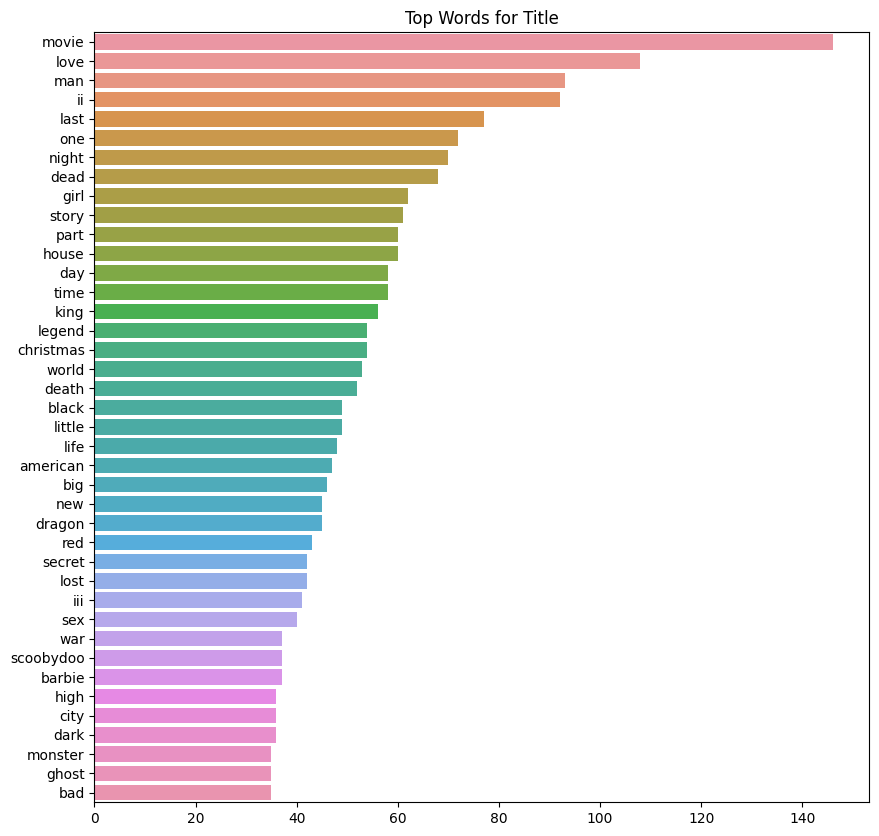

In [132]:
plot_top_words_barchart(data['Title'], 'Title')

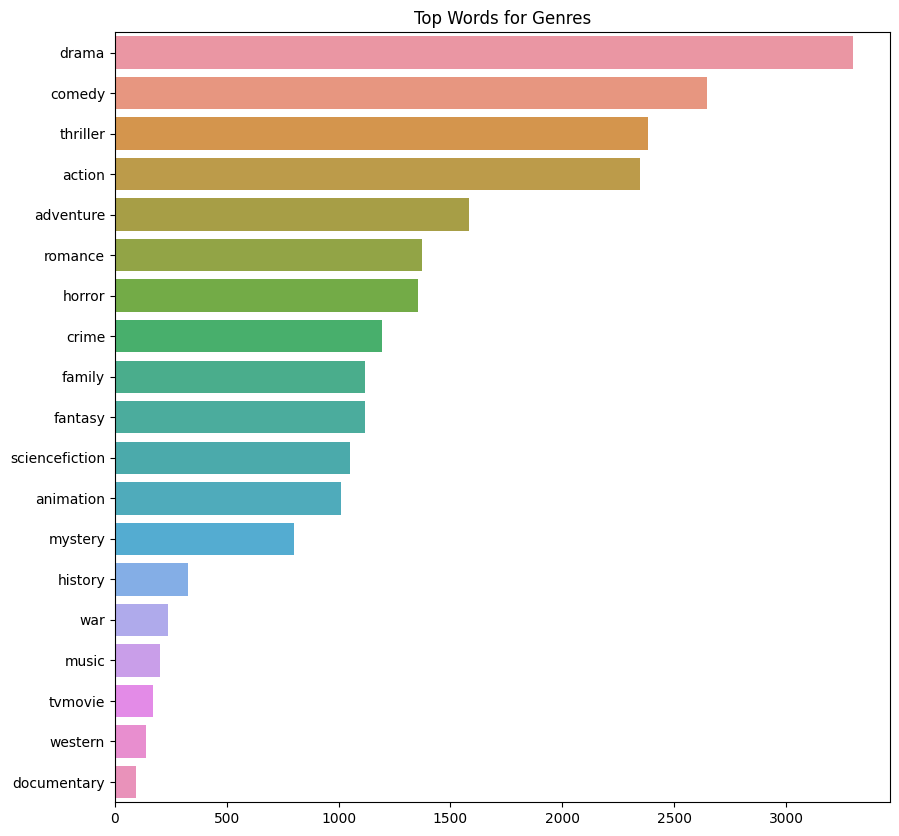

In [133]:
plot_top_words_barchart(data['Genres'], 'Genres')

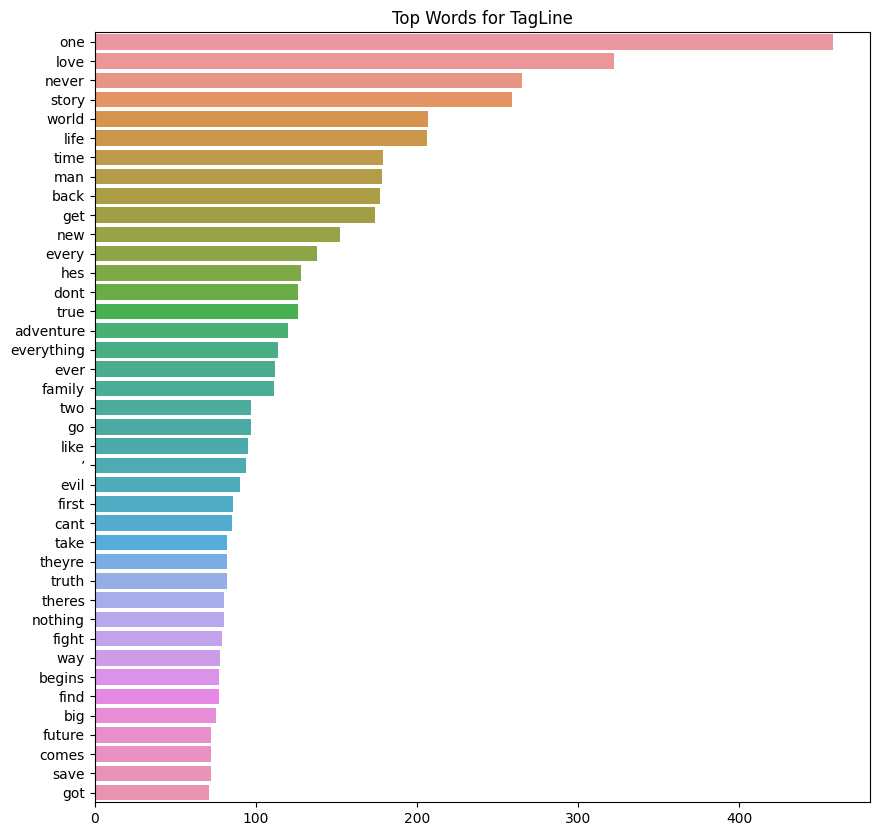

In [134]:
plot_top_words_barchart(data['TagLine'], 'TagLine')

Note: We identfied thanks to the previous graph, the top most frequent words for overview and title are generaly posititive and neutral nature. In tems of genres, we see drama in the top, followed by comedy and thriller. 

### Top n-grams

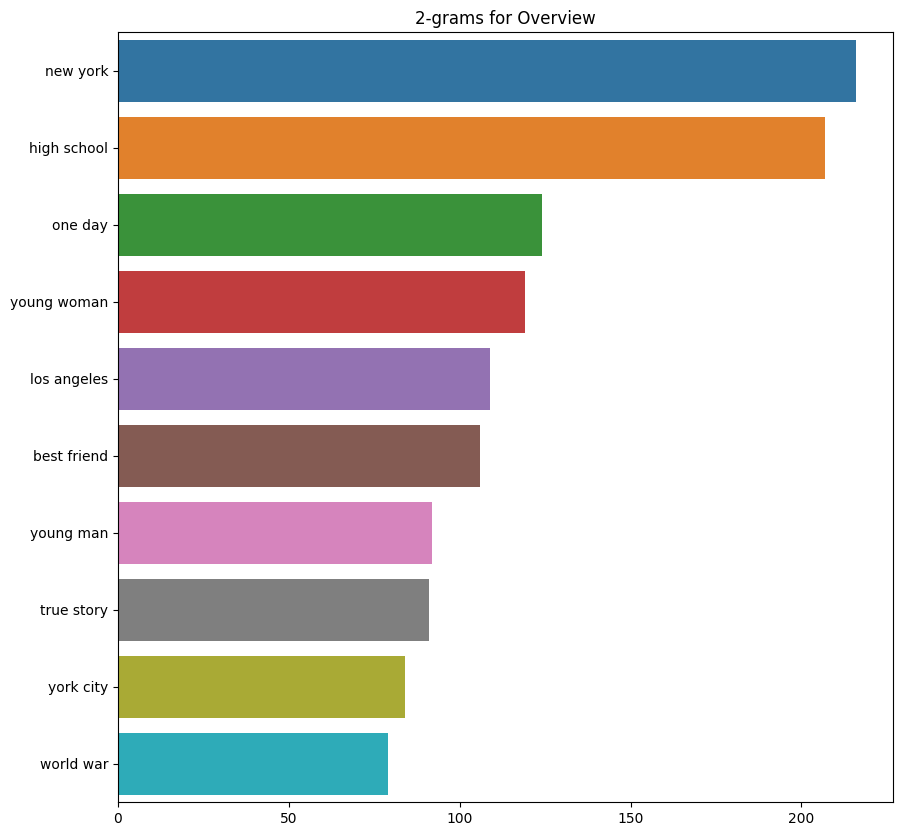

In [135]:
def plot_top_ngrams_barchart(text, column, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    plt.title(f'{n}-grams for {column}')

#2-grams for overview
plot_top_ngrams_barchart(data['Overview'],'Overview', 2)

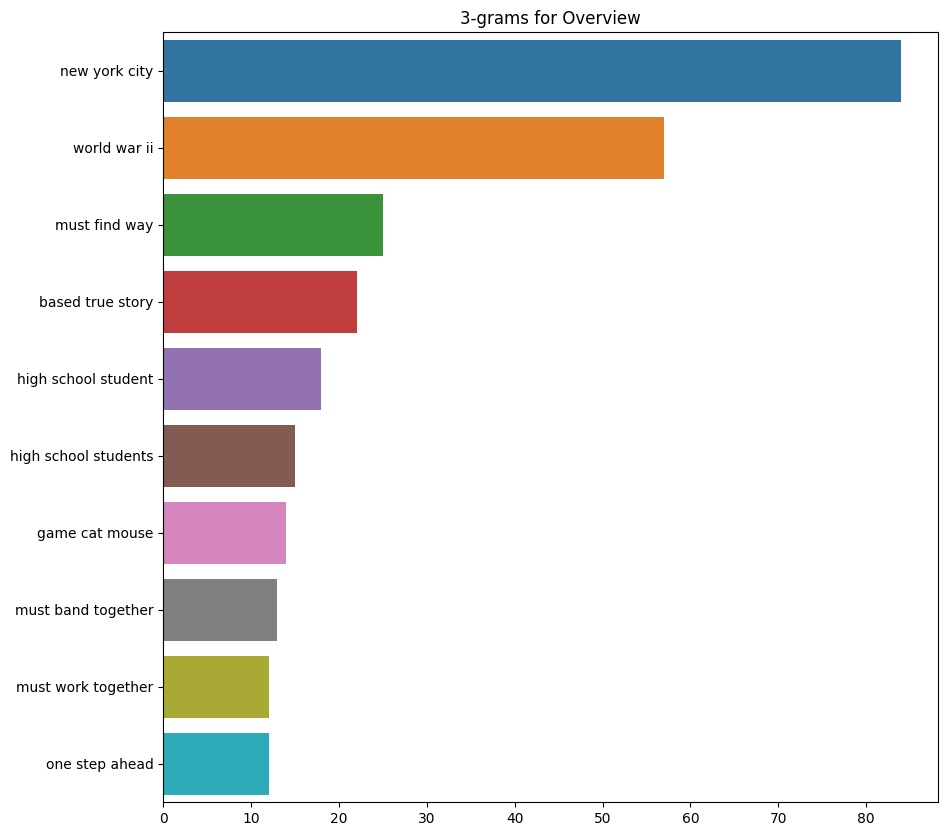

In [136]:
# 3 grams for Overview
plot_top_ngrams_barchart(data['Overview'],'Overview', 3)

- The top 2-gram found the the Overview column was new york, followed by high school and one day.
- The top 3-gram found in overview were new york city, followed by word war ii

## Numerical Data Visualizations

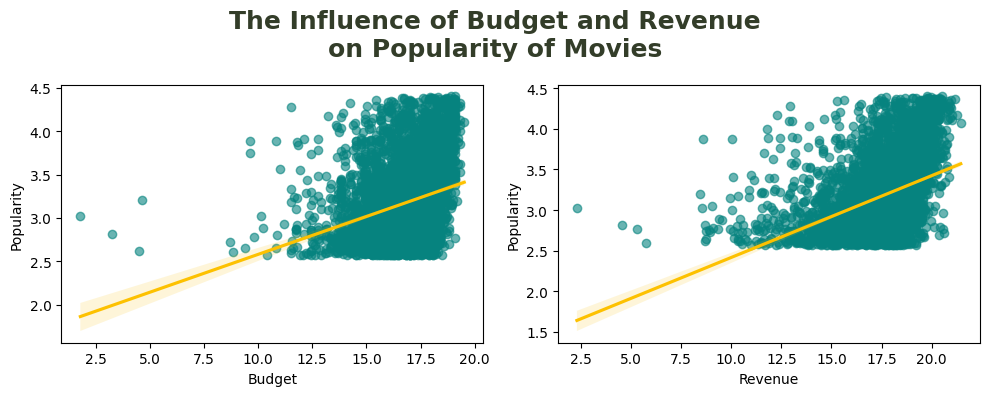

In [137]:
# The influence of budget and revenue in popularity

df_plot = data[(data['Budget'] != 0) & (data['Revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['Budget', 'Revenue']):
    sns.regplot(data=df_plot, x=col, y='Popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

Note: It can be seen how as higher the budget and revenue as higher is the Popularity

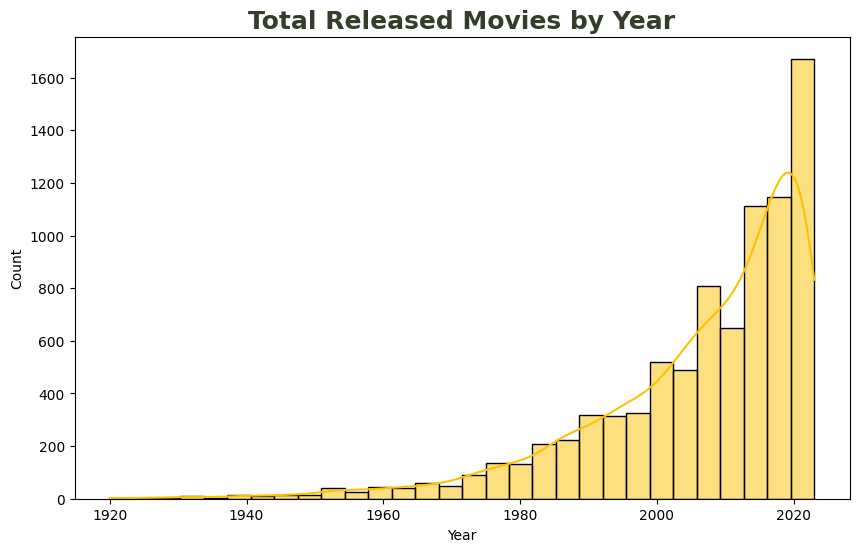

In [138]:
# Reviewing the total released movies by year

data['ReleaseDate'] = pd.to_datetime(data['ReleaseDate'])

# Extract the year from the 'ReleaseDate' column
data['Year'] = data['ReleaseDate'].dt.year

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Year', kde=True, color='#fdc100', bins=30)
plt.title('Total Released Movies by Year', fontsize=18, weight=600, color='#333d29')
plt.show()

Note: The total releases is higher for more recent years.

In [139]:
data.columns

Index(['OriginalLanguage', 'Overview', 'Popularity', 'ReleaseDate', 'Title',
       'VoteAverage', 'VoteCount', 'Budget', 'TagLine', 'RunTime', 'Revenue',
       'Genres', 'North America', 'Europe', 'Asia', 'Oceania', 'South America',
       'Africa\r\r\r', 'Year'],
      dtype='object')

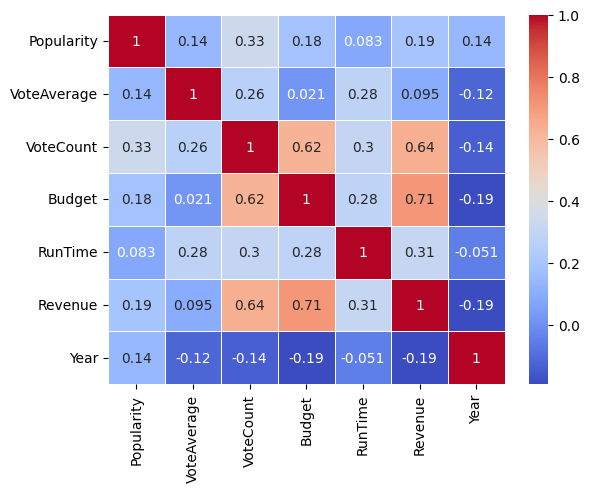

In [140]:
# Reviewing correlations between numerical columns

numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 'Year']

df_numericals = data[numerical_columns]

correlation_matrix = df_numericals.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


Note:

The above graph shows a potential correlation between Budget, VoteCount with Revenue. Therefore, only one of those can be used for the model.

## Pandas Profiling

In [141]:
from ydata_profiling import ProfileReport
profile = ProfileReport(data, title="Profiling Report")
profile.to_file("Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Notes:

The profiling report helps us to conclude the following:

- VoteCount is highly overall correlated with Budget and Revenue. Additionally, Budget and Revenue have a vast presence of zeros, 42% and 37%, respectively. Therefore, we decided to move forward with VoteCount and remove the other mentioned columns.
- We could see a high imbalance for the production continents. Additionally, high correlation with OriginalLanguage for some of the continents as Asia and North America. Therefore, we decided to remove for modeling the production continents and keep the OriginalLanguage column.




## Unsupervised Learning

In [142]:
data = pd.read_csv('movies_data_final.csv', lineterminator='\n', index_col='Id')
data['TagLine'].fillna('', inplace=True)

In [143]:
text_columns = ['Overview', 'Genres', 'TagLine']
data['joined_text'] = data[text_columns].apply(lambda x: ' '.join(x), axis=1)

### Topic Modeling LDA

In [216]:
def get_tfidf_lda_objects(text):   
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w) > 2]

            corpus.append(words)
        return corpus
    
    corpus = _preprocess_text(text)
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(doc) for doc in corpus])
    
    dic = corpora.Dictionary(corpus)
    tfidf_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model = models.LdaMulticore(tfidf_corpus, 
                                   num_topics=10, 
                                   id2word=dic,                                    
                                   passes=10,
                                   workers=2)
    
    return lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix

def plot_tfidf_lda_vis(lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, tfidf_corpus, dic, mds='tsne', R=15) 
    return vis

lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix = get_tfidf_lda_objects(data['Overview'])
lda_model.show_topics()

vis = plot_tfidf_lda_vis(lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix)

# Save the visualization as an HTML file
pyLDAvis.save_html(vis, 'lda_visualization_overview.html')


In [214]:
lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix = get_tfidf_lda_objects(data['joined_text'])
lda_model.show_topics()

plot_tfidf_lda_vis(lda_model, tfidf_corpus, dic, tfidf_vectorizer, tfidf_matrix)

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       4.496537 -52.081276       1        1  27.796320
9       8.609141  48.339046       2        1  19.337345
1      55.546238 -48.393433       3        1   9.645216
4      -1.402686   0.979143       4        1   9.121482
3     -30.536892 -24.895399       5        1   7.983828
6      58.777931  44.011391       6        1   6.979772
7      33.012764  16.083481       7        1   5.395821
8      70.321213  -3.701113       8        1   5.210660
5     -30.786234  26.105122       9        1   4.285185
2      28.830454 -21.147943      10        1   4.244370, topic_info=               Term         Freq        Total Category  logprob  loglift
143           drama  3364.000000  3364.000000  Default  15.0000  15.0000
0            action  2151.000000  2151.000000  Default  14.0000  14.0000
107          comedy  2713.000000  2713.000000  Default  13.0000  13.0000
187         romance  1548.000000  1548.000000  Default  12.0000  12.0000
160        thriller  2193.000000  2193.000000  Default  11.0000  11.0000
..              ...          ...          ...      ...      ...      ...
152             one    57.077764  1387.010029  Topic10  -5.3239  -0.0309
96              war    46.896610   626.838161  Topic10  -5.5204   0.5668
231          horror    52.435126  1269.377939  Topic10  -5.4087  -0.0271
251             new    46.810084  1189.670267  Topic10  -5.5222  -0.0758
23   sciencefiction    45.965262  1036.258768  Topic10  -5.5404   0.0441

[418 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0          1  0.359368  action
0          2  0.112506  action
0          3  0.088796  action
0          4  0.173873  action
0          5  0.024175  action
...      ...       ...     ...
241        7  0.030170   young
241        8  0.028446   young
241        9  0.031032   young
241       10  0.054307   young
26298      7  0.937054   yulia

[973 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 2, 5, 4, 7, 8, 9, 6, 3])

In [215]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, tfidf_corpus, dic, mds='tsne', R=15)
pyLDAvis.save_html(vis_data, 'lda_visualization_joined_text.html')

# To display the saved file in the notebook
from IPython.display import display, HTML
display(HTML('lda_visualization.html'))

In [244]:
import pandas as pd
import plotly_express as px

# Assuming 'Genres' is a column containing genre information in a list format
# If it's stored as a string, you'll need to convert it to a list first

# Define a function to handle conversion and filtering
def process_genres(genres):
    if isinstance(genres, str):
        return genres.split(', ')
    return []

# Apply the function to the 'Genres' column
df['Genres'] = df['Genres'].apply(process_genres)

# Create a list to store all genres
all_genres = []

# Loop through each row and add genres to the list
for genres in df['Genres']:
    all_genres.extend(genres)

# Create a DataFrame for genre counts
genre_counts = pd.DataFrame(all_genres, columns=['Genre'])
genre_counts = genre_counts['Genre'].value_counts().reset_index()

# Create the Sunburst Diagram
fig = px.sunburst(genre_counts, path=['index'], values='Genre')

fig.update_layout(title='Genre Sunburst Diagram')
fig.show()

ModuleNotFoundError: No module named 'plotly_express'

In [229]:
df['Genres']

0       Action, Adventure, Thriller
1           Action, Thriller, Crime
2        Animation, Action, Fantasy
3                  Action, Thriller
4                   Thriller, Drama
                   ...             
9995        Action, Crime, Thriller
9996        Drama, Action, Thriller
9997                  Drama, Comedy
9998                          Drama
9999     Music, Documentary, Family
Name: Genres, Length: 9930, dtype: object

### Clustering K-means

In [146]:
R = data['VoteAverage']
v = data['VoteCount']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = data['VoteCount'].quantile(0.8)
C = data['VoteAverage'].mean()

data['weighted_average'] = (R*v + C*m)/(v+m)

In [147]:
# Selected columns based on previous feaure analysis
data['ReleaseDate'] = pd.to_datetime(data['ReleaseDate'])
data['Year'] = data['ReleaseDate'].dt.year
text_columns = ['Overview', 'Genres', 'TagLine']

In [148]:
# Textual data vectorizing

joined_text = data['joined_text'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(joined_text)

# Feature engineeing  a columns called score
data['score'] = data['weighted_average']*0.4 + data['Popularity'].astype('float64')*0.6

# Numerical features scaling
numerical_features = ['Popularity', 'weighted_average', 'score', 'Year', 'RunTime', 'VoteCount']
X_numerical = data[numerical_features].values
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

X_original_language = data['OriginalLanguage'].values

X_numerical_scaled_final = np.concatenate((X_original_language.reshape(-1, 1), X_numerical_scaled), axis=1)
X_combined = np.concatenate((X_tfidf.toarray(), X_numerical_scaled), axis=1)

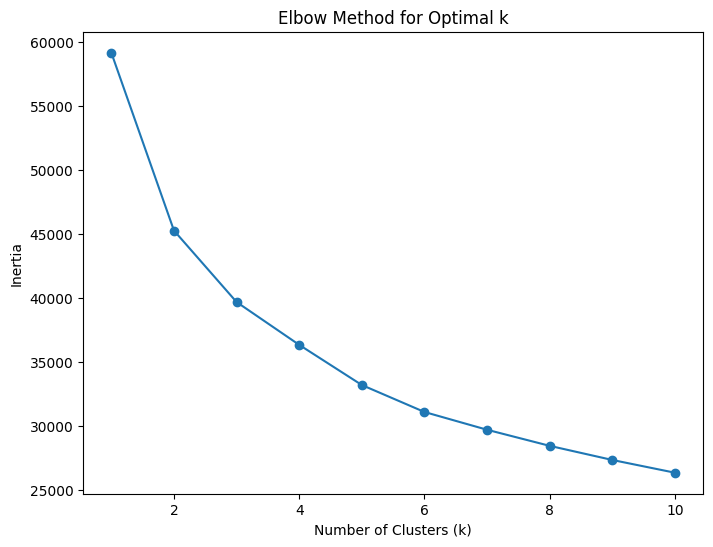

In [149]:
# Elbow Method Analysis

inertia = []
max_k = 10
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k+1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [152]:
# K-means with k = 6

k = 8
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X_combined)

data['Cluster'] = clusters

data[['joined_text', 'Cluster']]

,joined_text,Cluster
Id,,
27205,cobb skilled thief commits corporate espionage...,2
497698,natasha romanoff also known black widow confro...,2
603,set 22nd century matrix tells story computer h...,2
843794,uninhabitable 22ndcentury earth outcome civil ...,4
446893,queen poppy branch make surprising discovery —...,2
...,...,...
2749,eastern european criminals oleg emil come new ...,0
11128,watchful eye mentor captain mike kennedy proba...,0
484482,40yearold bertrand suffering depression last t...,1


The clusters are not evident using this dimension reduction. We will proceede to create other analysis to understand the difference between clusters.

In [163]:
df.head()

,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,TagLine,RunTime,Revenue,Genres,North America,Europe,Asia,Oceania,South America,Africa
0,299054,1,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,They'll die when they're dead.,103,30000000,"Action, Adventure, Thriller",0,0,0,0,0,0
1,926393,1,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,Justice knows no borders.,109,176933602,"Action, Thriller, Crime",1,0,0,0,0,0
2,1034062,1,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,Neon lights... Suits with shoulder pads... Jum...,80,0,"Animation, Action, Fantasy",1,0,0,0,0,0
3,575264,1,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,We all share the same fate.,164,567148955,"Action, Thriller",1,0,0,0,0,0
4,1151534,0,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,Attempting to survive in the middle of nowhere...,109,0,"Thriller, Drama",0,0,0,0,0,0


In [164]:
df.shape

(9930, 20)

In [165]:
df.columns

Index(['Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity',
       'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount', 'Budget', 'TagLine',
       'RunTime', 'Revenue', 'Genres', 'North America', 'Europe', 'Asia',
       'Oceania', 'South America', 'Africa'],
      dtype='object')

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9930 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                9930 non-null   int64         
 1   OriginalLanguage  9930 non-null   int64         
 2   OriginalTitle     9930 non-null   object        
 3   Overview          9930 non-null   object        
 4   Popularity        9930 non-null   float64       
 5   ReleaseDate       9930 non-null   datetime64[ns]
 6   Title             9930 non-null   object        
 7   VoteAverage       9930 non-null   float64       
 8   VoteCount         9930 non-null   int64         
 9   Budget            9930 non-null   int64         
 10  TagLine           9930 non-null   object        
 11  RunTime           9930 non-null   int64         
 12  Revenue           9930 non-null   int64         
 13  Genres            9930 non-null   object        
 14  North America     9930 non-nu

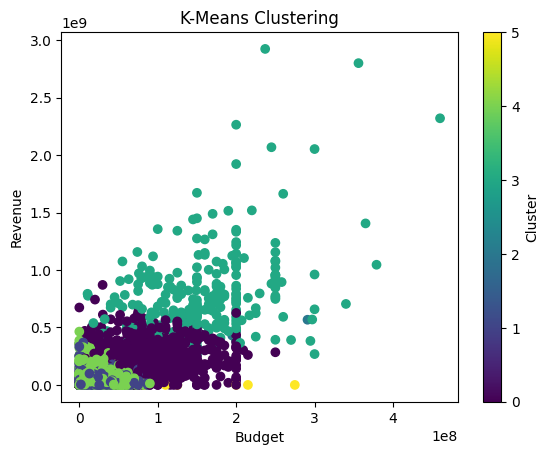

In [188]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

num_clusters = 6 
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster_KMeans'] = clusters

plt.scatter(X['Budget'], X['Revenue'], c=clusters, cmap='viridis')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

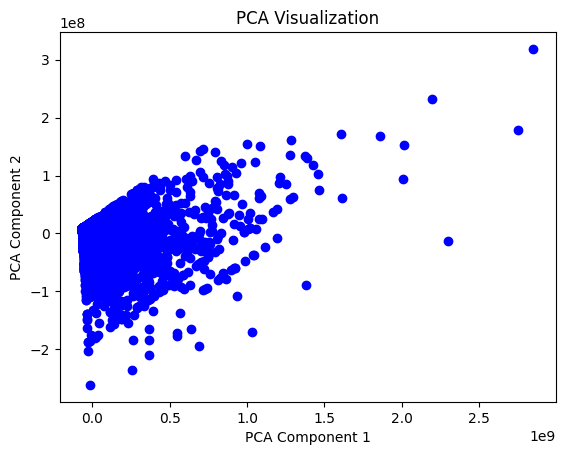

In [174]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 
            'North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']
X = df[features]

pca = PCA(n_components=4) 
X_pca = pca.fit_transform(X)

df['PCA_Component_1'] = X_pca[:, 0]
df['PCA_Component_2'] = X_pca[:, 1]

plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c='blue')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.show()

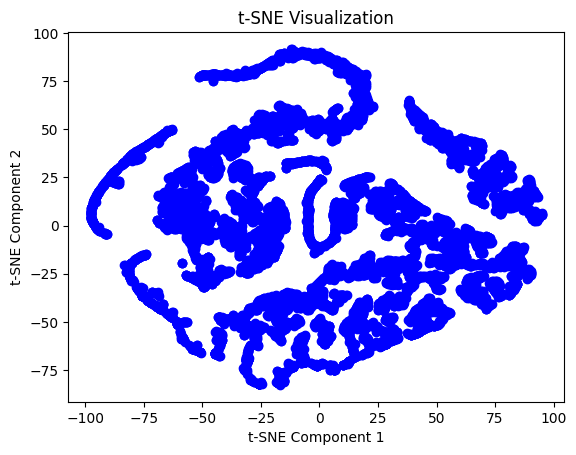

In [172]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 
            'North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']
X = df[features]

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

df['t-SNE_Component_1'] = X_tsne[:, 0]
df['t-SNE_Component_2'] = X_tsne[:, 1]

plt.scatter(df['t-SNE_Component_1'], df['t-SNE_Component_2'], c='blue')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()

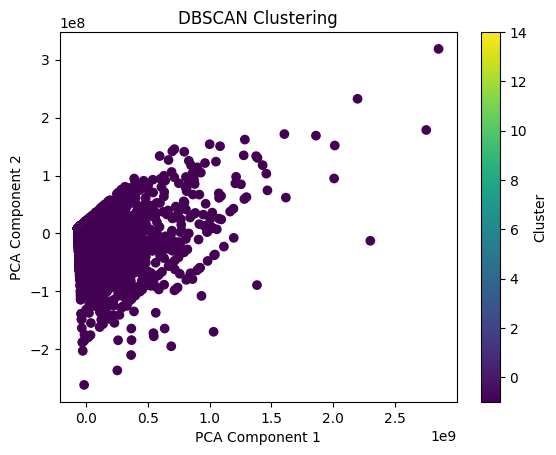

In [218]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

features = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 
            'North America', 'Europe', 'Asia', 'Oceania', 'South America', 'Africa']
X = df[features]

dbscan = DBSCAN(eps=5, min_samples=10)
clusters = dbscan.fit_predict(X)

df['Cluster_DBSCAN'] = clusters

plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c=df['Cluster_DBSCAN'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.show()

In [179]:
import re

def clean_text(text):
    text = re.sub(r"^https://t.co/[a-zA-Z0-9]*\s", " ", text)
    text = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*\s", " ", text)
    text = re.sub(r"\s+https://t.co/[a-zA-Z0-9]*$", " ", text)
    text = text.lower()
    text = re.sub(r"that's","that is",text)
    text = re.sub(r"there's","there is",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"where's","where is",text)
    text = re.sub(r"it's","it is",text)
    text = re.sub(r"who's","who is",text)
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"he's","he is",text)
    text = re.sub(r"they're","they are",text)
    text = re.sub(r"who're","who are",text)
    text = re.sub(r"ain't","am not",text)
    text = re.sub(r"wouldn't","would not",text)
    text = re.sub(r"shouldn't","should not",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"couldn't","could not",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"\W"," ",text)
    text = re.sub(r"\d"," ",text)
    text = re.sub(r"\s+[a-z]\s+"," ",text)
    text = re.sub(r"\s+[a-z]$"," ",text)
    text = re.sub(r"^[a-z]\s+"," ",text)
    text = re.sub(r"\s+"," ",text)
    return text

# Assuming df is your DataFrame with a column named 'Overview'
df['Cleaned_Overview'] = df['Overview'].apply(clean_text)

In [180]:
df['Cleaned_Overview']

0       armed with every weapon they can get their han...
1       robert mccall finds himself at home in souther...
2       in hollywood action star johnny cage is lookin...
3       ethan hunt and his imf team embark on their mo...
4        young pregnant woman named mia escapes from c...
                              ...                        
9995    when eastern european criminals oleg and emil ...
9996    under the watchful eye of his mentor captain m...
9997     year old bertrand has been suffering from dep...
9998     man stranded in the arctic is finally about t...
9999    tells the story of justin bieber the kid from ...
Name: Cleaned_Overview, Length: 9930, dtype: object

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

max_features = len(df)
min_df = int(0.01 * max_features) 
max_df = int(0.9 * max_features)   

vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df, stop_words='english')
with open('tfidfmodel.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

In [186]:
with open('tfidfmodel.pickle', 'rb') as f:
    tfidf = pickle.load(f)
    
X_tfidf = tfidf.transform(df['Cleaned_Overview']).toarray()

NotFittedError: The TF-IDF vectorizer is not fitted